In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import joblib
from itertools import product
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import shap

In [19]:
# Load 2016-19 data
data = pd.read_csv('data/batting_season_summary.csv')

In [20]:
data.shape

(2700, 18)

In [21]:
data.tail()

Name  age      team pos   PA   AB    H  2B  3B  HR  BB  \
2695      Victor Garate   29  Phillies  RF  646  582  162  40  30   7  64   
2696      Vince Belnome   31    Giants  SS  710  671  176  47  28  12  39   
2697        Wes Whisler   32      Reds  2B  722  649  217  52  25  18  73   
2698     Wilfredo Tovar   27  Mariners  1B  756  673  147  41  22   1  83   
2699  Wilking Rodriguez   34     Twins  2B  707  644  153  39  30   5  63   

       SO      P/PA        BA       OBP       SLG       OPS  Year  
2695  127  3.433437  0.278351  0.349845  0.486254  0.836099  2023  
2696   96  2.885915  0.262295  0.302817  0.469449  0.772265  2023  
2697   78  3.038781  0.334361  0.401662  0.574730  0.976392  2023  
2698  194  3.630952  0.218425  0.304233  0.349183  0.653416  2023  
2699  246  3.773692  0.237578  0.305516  0.414596  0.720113  2023

In [22]:
label_encoder = LabelEncoder()
data["playerid"] = label_encoder.fit_transform(data["Name"])

data['playerid'] = data['playerid'].astype('int')

In [23]:
data.head()

Name  age      team pos   PA   AB    H  2B  3B  HR  BB   SO  \
0  Abel De Los Santos   25      Cubs  1B  721  676  151  36  28   4  45  170   
1    Adalberto Mendez   28  Phillies  LF  653  623  110  19  18   3  30  104   
2      Adam Greenberg   28   Pirates  RF  579  514  144  29  21  12  65  112   
3       Adam Peterson   21    Braves  1B  742  668  192  45  40  10  74  161   
4        Adam Shabala   34  Mariners  SS  637  600  109  26  12  10  37  143   

       P/PA        BA       OBP       SLG       OPS  Year  playerid  
0  3.353675  0.223373  0.271845  0.377219  0.649064  2014         2  
1  2.980092  0.176565  0.214395  0.279294  0.493689  2014         3  
2  3.414508  0.280156  0.360967  0.488327  0.849294  2014         5  
3  3.357143  0.287425  0.358491  0.519461  0.877952  2014         6  
4  3.175824  0.181667  0.229199  0.315000  0.544199  2014         7

## Modeling Part 1: XGBoost Regressor

In [24]:
# Set random state for reproducibility
RANDOMSTATE=120

# Define reproducible k-folds for cross-validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)

In [25]:
# Set default hyperparameters
param_dict = {'n_estimators':500, 'learning_rate':0.01, 'max_depth':5, 'subsample':0.4, 'colsample_bytree':0.3}

In [26]:
def tuning(xtrain, ytrain, name):
    """Function to build XGBoost models and tune hyperparameters in multiple steps."""

    # Reset default hyperparameters
    param_dict = {'n_estimators':500, 'learning_rate':0.01, 'max_depth':5, 'subsample':0.4, 'colsample_bytree':0.3}
    
    # Define and train base model
    base_model = xgb.XGBRegressor(eval_metric='rmse', **param_dict, verbosity=0)
    print(base_model)
    base_model.fit(xtrain, ytrain)
    score = base_model.score(xtrain, ytrain)   
    print("Training score: ", score) 

    # Cross-validatation 
    scores = -cross_val_score(base_model, xtrain, ytrain, cv=5, scoring='neg_mean_absolute_error')
    print("Mean cross-validation score: %.2f" % scores.mean())

    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    kf_cv_scores = -cross_val_score(base_model, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_error')
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    # Predict test data with base model
    base_ypred = base_model.predict(xtest)
    base_mae = mean_absolute_error(ytest, base_ypred)
    base_mse = mean_squared_error(ytest, base_ypred)
    print("MAE: %.2f" % base_mae)
    print("MSE: %.2f" % base_mse)
    print("RMSE: %.2f" % (base_mse**(1/2.0)))

    # Plot model performance
    x_ax = range(len(ytest))
    plt.scatter(x_ax, ytest, s=5, color="blue", label="actual")
    plt.plot(x_ax, base_ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    # Display and save feature importance chart
    xgb.plot_importance(base_model, max_num_features = 15)
    plt.tight_layout()
    plt.savefig('base_'+name+'_1619.png')
    plt.show()
    
    # Display one decision tree
    fig, ax = plt.subplots(figsize=(30, 30))
    xgb.plot_tree(base_model, num_trees=20, rankdir='LR', ax=ax)
    plt.show()

    # Hyperparameter grid search step 1: max depth
    model = xgb.XGBRegressor(eval_metric='rmse', **param_dict)
    print(model)
    max_depth = range(3, 9, 1)
    param_grid = dict(max_depth=max_depth)
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['max_depth'] = grid_result.best_params_['max_depth']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 2: subsample, colsample_bytree
    model2 = xgb.XGBRegressor(eval_metric='rmse', **param_dict)
    print(model2)
    subsample = np.linspace(0.4, 1.0, 7)
    colsample_bytree = np.linspace(0.1, 0.35, 6)
    param_grid = dict(subsample=subsample, colsample_bytree=colsample_bytree, max_depth=[grid_result.best_params_['max_depth']])
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    grid_search = GridSearchCV(model2, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['subsample'] = grid_result.best_params_['subsample']
    param_dict['colsample_bytree'] = grid_result.best_params_['colsample_bytree']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 3: learning rate
    model3 = xgb.XGBRegressor(eval_metric='rmse', **param_dict)
    print(model3)
    learning_rate = [0.0001, 0.001, 0.01, 0.1]
    param_grid = dict(learning_rate=learning_rate, subsample=[grid_result.best_params_['subsample']], 
                      colsample_bytree=[grid_result.best_params_['colsample_bytree']], 
                      max_depth=[grid_result.best_params_['max_depth']])
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    grid_search = GridSearchCV(model3, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['learning_rate'] = grid_result.best_params_['learning_rate']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 4: number of estimators
    model4 = xgb.XGBRegressor(eval_metric='rmse', **param_dict)
    print(model4)
    n_estimators = [100, 200, 300, 400, 500]
    param_grid = dict(n_estimators=n_estimators, learning_rate=[grid_result.best_params_['learning_rate']], 
                      subsample=[grid_result.best_params_['subsample']], 
                      colsample_bytree=[grid_result.best_params_['colsample_bytree']], 
                      max_depth=[grid_result.best_params_['max_depth']])
    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    grid_search = GridSearchCV(model4, param_grid, scoring='neg_mean_absolute_error', n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['n_estimators'] = grid_result.best_params_['n_estimators']
    best_params_list.append(param_dict)
    print(grid_result.best_score_, grid_result.best_params_)
    
    # Train best parameter model    
    model5 = xgb.XGBRegressor(eval_metric='rmse', **param_dict)
    model5.fit(xtrain, ytrain)

    score = model5.score(xtrain, ytrain)   
    print("Training score: ", score) 

    # Cross-validataion 
    scores = -cross_val_score(model5, xtrain, ytrain, cv=5, scoring='neg_mean_absolute_error')
    print("Mean cross-validation score: %.2f" % scores.mean())

    kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
    kf_cv_scores = -cross_val_score(model5, xtrain, ytrain, cv=kfold, scoring='neg_mean_absolute_error')
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    # Predict test set
    ypred = model5.predict(xtest)
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    print("MAE: %.2f" % mae)
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % (mse**(1/2.0)))

    # Plot model performance
    x_ax = range(len(ytest))
    plt.scatter(x_ax, ytest, s=5, color="blue", label="actual")
    plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    # Save model
    joblib.dump(model5, name+"_1619.joblib.dat")
    
    # Display feature importance table
    xgb.plot_importance(model5, max_num_features = 15)
    plt.tight_layout()
    plt.savefig(name+'_1619.png')
    plt.show()
    
    # Display one decision tree
    fig, ax = plt.subplots(figsize=(30, 30))
    xgb.plot_tree(model5, num_trees=20, rankdir='LR', ax=ax)
    plt.show()

In [30]:
# Define features and target variable
X = data.drop(['playerid', 'Name', "3B", "AB", "BB"], axis=1)
y = data['H']

In [ ]:
# Define all target variables
ypa = data['PA_Tgt']
yab = data['AB_Tgt']
yr = data['R_Tgt']
yhr = data['HR_Tgt']
yrbi = data['RBI_Tgt']
ysb = data['SB_Tgt']
ycs = data['CS_Tgt']
yavg = data['AVG_Tgt']
yobp = data['OBP_Tgt']
yops = data['OPS_Tgt']
ydol = data['Dol_Tgt']

# Define lists of target variables and names
ys = [data['PA_Tgt'], data['AB_Tgt'], data['R_Tgt'], data['HR_Tgt'], data['RBI_Tgt'], data['SB_Tgt'], data['CS_Tgt'], data['AVG_Tgt'], data['OBP_Tgt'], data['OPS_Tgt'], data['Dol_Tgt']]
names = ['ypa', 'yab', 'yr', 'yhr', 'yrbi', 'ysb', 'ycs', 'yavg', 'yobp', 'yops', 'ydol']
stat_names = ['PA', 'AB', 'R', 'HR', 'RBI', 'SB', 'CS', 'AVG', 'OBP', 'OPS', 'Dol']
baselines = [data['PA_Lag1'], data['AB_Lag1'], data['R_Lag1'], data['HR_Lag1'], data['RBI_Lag1'], data['SB_Lag1'], data['CS_Lag1'], data['AVG_Lag1'], data['OBP_Lag1'], data['OPS_Lag1'], data['Dol_Lag1']]
models = []
best_params_list = []

In [ ]:
# Run tuning function for all target variables
for i in range(len(ys)):
    print(names[i],':')
    y = ys[i]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=RANDOMSTATE)
    tuning(xtrain, ytrain, names[i])

NameError: name 'ys' is not defined

In [ ]:
# Construct dictionary of best hyperparameters for all stats.
dict(zip(stat_names,best_params_list))

{'PA': {'n_estimators': 500,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.5,
  'colsample_bytree': 0.25},
 'AB': {'n_estimators': 100,
  'learning_rate': 0.01,
  'max_depth': 4,
  'subsample': 0.4,
  'colsample_bytree': 0.35},
 'R': {'n_estimators': 400,
  'learning_rate': 0.01,
  'max_depth': 4,
  'subsample': 0.5,
  'colsample_bytree': 0.15},
 'HR': {'n_estimators': 500,
  'learning_rate': 0.01,
  'max_depth': 4,
  'subsample': 0.6,
  'colsample_bytree': 0.3},
 'RBI': {'n_estimators': 500,
  'learning_rate': 0.01,
  'max_depth': 6,
  'subsample': 0.4,
  'colsample_bytree': 0.3},
 'SB': {'n_estimators': 400,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.4,
  'colsample_bytree': 0.35},
 'CS': {'n_estimators': 300,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.7,
  'colsample_bytree': 0.35},
 'AVG': {'n_estimators': 500,
  'learning_rate': 0.01,
  'max_depth': 3,
  'subsample': 0.4,
  'colsample_bytree': 0.25},
 'OBP': {'n_estimators': 500,
  '

In [ ]:
params_2016_19 = list(zip(names,best_params_list))
params_2016_19

[('ypa',
  {'n_estimators': 500,
   'learning_rate': 0.01,
   'max_depth': 3,
   'subsample': 0.5,
   'colsample_bytree': 0.25}),
 ('yab',
  {'n_estimators': 100,
   'learning_rate': 0.01,
   'max_depth': 4,
   'subsample': 0.4,
   'colsample_bytree': 0.35}),
 ('yr',
  {'n_estimators': 400,
   'learning_rate': 0.01,
   'max_depth': 4,
   'subsample': 0.5,
   'colsample_bytree': 0.15}),
 ('yhr',
  {'n_estimators': 500,
   'learning_rate': 0.01,
   'max_depth': 4,
   'subsample': 0.6,
   'colsample_bytree': 0.3}),
 ('yrbi',
  {'n_estimators': 500,
   'learning_rate': 0.01,
   'max_depth': 6,
   'subsample': 0.4,
   'colsample_bytree': 0.3}),
 ('ysb',
  {'n_estimators': 400,
   'learning_rate': 0.01,
   'max_depth': 3,
   'subsample': 0.4,
   'colsample_bytree': 0.35}),
 ('ycs',
  {'n_estimators': 300,
   'learning_rate': 0.01,
   'max_depth': 3,
   'subsample': 0.7,
   'colsample_bytree': 0.35}),
 ('yavg',
  {'n_estimators': 500,
   'learning_rate': 0.01,
   'max_depth': 3,
   'subsample

## Modeling Part 2: XGBoost Classifier

In [ ]:
# Load 2016-19 dataset

dfc = pd.read_csv('2016-19_batting.csv')

In [ ]:
# Set feature values to 2016-19 dataset.

Xc = dfc.drop(['playerid', 'Name', 'Team', 'League', 'Team_Traded', 'League_Traded', 'Team_Lag1', 
          'League_Lag1', 'PA_Tgt', 'AB_Tgt', 'R_Tgt', 'HR_Tgt', 'RBI_Tgt', 'SB_Tgt', 'CS_Tgt', 'AVG_Tgt', 'OBP_Tgt', 'OPS_Tgt', 
            'Dol_Tgt', 'PA_Tgt_Cat', 'R_Tgt_Cat', 'HR_Tgt_Cat', 'RBI_Tgt_Cat', 'SB_Tgt_Cat', 'CS_Tgt_Cat', 'AVG_Tgt_Cat', 
            'OBP_Tgt_Cat', 'OPS_Tgt_Cat', 'Dol_Tgt_Cat', 'PA_Tgt_Code', 'R_Tgt_Code', 'HR_Tgt_Code', 'RBI_Tgt_Code', 
            'SB_Tgt_Code', 'CS_Tgt_Code', 'AVG_Tgt_Code', 'OBP_Tgt_Code', 'OPS_Tgt_Code', 'Dol_Tgt_Code', 'Season'
            ], axis=1)

yc = dfc['PA_Tgt_Code']

# Define target values

ypac = dfc['PA_Tgt_Code']
yrc = dfc['R_Tgt_Code']
yhrc = dfc['HR_Tgt_Code']
yrbic = dfc['RBI_Tgt_Code']
ysbc = dfc['SB_Tgt_Code']
ycsc = dfc['CS_Tgt_Code']
yavgc = dfc['AVG_Tgt_Code']
yobpc = dfc['OBP_Tgt_Code']
yopsc = dfc['OPS_Tgt_Code']
ydolc = dfc['Dol_Tgt_Code']

# Build lists of target variables and names
ycs = [dfc['PA_Tgt_Code'], dfc['R_Tgt_Code'], dfc['HR_Tgt_Code'], dfc['RBI_Tgt_Code'], dfc['SB_Tgt_Code'], 
      dfc['CS_Tgt_Code'], dfc['AVG_Tgt_Code'], dfc['OBP_Tgt_Code'], dfc['OPS_Tgt_Code'], dfc['Dol_Tgt_Code']]
names = ['ypac', 'yrc', 'yhrc', 'yrbic', 'ysbc', 'ycsc', 'yavgc', 'yobpc', 'yopsc', 'ydolc']

# Define list of non-outlier labels for each statistic
nonoutliers = [1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
def clf_tuning(xtrain, ytrain, name, kfold, nonoutlier):
    """Function to build XGBoost classifier models and tune hyperparameters in multiple steps."""

    # Reset default hyperparameters
    param_dict = {'n_estimators':500, 'learning_rate':0.01, 'max_depth':5, 
                  'subsample':0.5, 'colsample_bytree':0.3}
    
    # Define and train base model
    base_model = xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False)
    print(base_model)
    base_model.fit(xtrain, ytrain)
    score = base_model.score(xtrain, ytrain)   
    print("Training score: ", score) 

    # Cross-validataion 
    
    # Construct pipeline to run SMOTE oversampling for each fold of cross-validation
    imb_pipeline = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                              xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    
    scores = cross_val_score(imb_pipeline, xtrain, ytrain, scoring='f1_micro', cv=5)
    print("Mean cross-validation score: %.2f" % scores.mean())
    kf_cv_scores = cross_val_score(imb_pipeline, xtrain, ytrain, scoring='f1_micro', cv=kfold)
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    # Predict test set using base model
    base_ypred = base_model.predict(xtest)
    base_precision = precision_score(ytest, base_ypred, average='weighted')
    base_recall = recall_score(ytest, base_ypred, average='weighted')
    print("Precision: %.2f%%" % (base_precision * 100.0))
    print("Recall: %.2f%%" % (base_recall * 100.0))
    
    # Define outlier precision and recall measures to exclude non-outlier values
    base_outlier_precision = precision_score(ytest[ytest!=nonoutlier], base_ypred[ytest!=nonoutlier], average='weighted')
    base_outlier_recall = recall_score(ytest[ytest!=nonoutlier], base_ypred[ytest!=nonoutlier], average='weighted')
    print("Outlier Precision: %.2f%%" % (base_outlier_precision * 100.0))
    print("Outlier Recall: %.2f%%" % (base_outlier_recall * 100.0))
    
    # Plot model performance
    x_ax = range(len(ytest))
    plt.scatter(x_ax, ytest, s=5, color="blue", label="actual")
    plt.plot(x_ax, base_ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    # Display and save feature importance chart
    xgb.plot_importance(base_model, max_num_features = 15)
    plt.tight_layout()
    plt.savefig('base_clf_'+name+'.png')
    plt.show()

    # Hyperparameter grid search step 1: max depth
    param_dict = {'xgbclassifier__n_estimators':500, 'xgbclassifier__learning_rate':0.01, 'xgbclassifier__max_depth':5, 
                  'xgbclassifier__subsample':0.1, 'xgbclassifier__colsample_bytree':0.3}
    
    model = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                           xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    print(model)
    max_depth = range(3, 9, 1)
    param_grid = dict(xgbclassifier__max_depth=max_depth)
    grid_search = GridSearchCV(model, param_grid, scoring='f1_micro', n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['xgbclassifier__max_depth'] = grid_result.best_params_['xgbclassifier__max_depth']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 2: subsample, colsample_bytree
    model2 = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                           xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    print(model2)
    subsample = np.linspace(0.4, 1, 7)
    colsample_bytree = np.linspace(0.1, 0.35, 6)
    param_grid = dict(xgbclassifier__subsample=subsample, xgbclassifier__colsample_bytree=colsample_bytree, 
                      xgbclassifier__max_depth=[grid_result.best_params_['xgbclassifier__max_depth']])
    grid_search = GridSearchCV(model2, param_grid, scoring='f1_micro', n_jobs=-1, cv=kfold, return_train_score=True, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['xgbclassifier__subsample'] = grid_result.best_params_['xgbclassifier__subsample']
    param_dict['xgbclassifier__colsample_bytree'] = grid_result.best_params_['xgbclassifier__colsample_bytree']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 3: learning rate
    model3 = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                           xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    print(model3)
    learning_rate = [0.0001, 0.001, 0.01, 0.1]
    param_grid = dict(xgbclassifier__learning_rate=learning_rate, 
                      xgbclassifier__subsample=[grid_result.best_params_['xgbclassifier__subsample']], 
                      xgbclassifier__colsample_bytree=[grid_result.best_params_['xgbclassifier__colsample_bytree']], 
                      xgbclassifier__max_depth=[grid_result.best_params_['xgbclassifier__max_depth']])
    grid_search = GridSearchCV(model3, param_grid, scoring='f1_micro', n_jobs=-1, cv=kfold, return_train_score=True, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['xgbclassifier__learning_rate'] = grid_result.best_params_['xgbclassifier__learning_rate']
    print(grid_result.best_score_, grid_result.best_params_)

    # Hyperparameter grid search step 4: number of estimators
    model4 = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                           xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    print(model4)
    n_estimators = [100, 200, 300, 400, 500]
    param_grid = dict(xgbclassifier__n_estimators=n_estimators, 
                      xgbclassifier__learning_rate=[grid_result.best_params_['xgbclassifier__learning_rate']], 
                      xgbclassifier__subsample=[grid_result.best_params_['xgbclassifier__subsample']], 
                      xgbclassifier__colsample_bytree=[grid_result.best_params_['xgbclassifier__colsample_bytree']], 
                      xgbclassifier__max_depth=[grid_result.best_params_['xgbclassifier__max_depth']])
    grid_search = GridSearchCV(model4, param_grid, scoring='f1_micro', n_jobs=-1, cv=kfold, return_train_score=True, verbose=1)
    grid_result = grid_search.fit(xtrain, ytrain)
    param_dict['xgbclassifier__n_estimators'] = grid_result.best_params_['xgbclassifier__n_estimators']
    best_params_list.append(param_dict)
    print(grid_result.best_score_, grid_result.best_params_)
    
    # Train best parameter model
    
    model5 = make_pipeline(SMOTE(random_state=RANDOMSTATE), 
                           xgb.XGBClassifier(eval_metric='merror', **param_dict, verbosity=0, use_label_encoder=False))
    
    model5.fit(xtrain, ytrain)
    score = model5.score(xtrain, ytrain)   
    print("Training score: ", score) 

    # Cross-validataion 
    scores = cross_val_score(model5, xtrain, ytrain, cv=5, scoring='f1_micro')
    print("Mean cross-validation score: %.2f" % scores.mean())
    kf_cv_scores = cross_val_score(model5, xtrain, ytrain, cv=kfold, scoring='f1_micro')
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

    # Predict test set with best parameter model
    ypred = model5.predict(xtest)
    precision = precision_score(ytest, ypred, average='weighted')
    recall = recall_score(ytest, ypred, average='weighted')
    print("Precision: %.2f%%" % (precision * 100.0))
    print("Recall: %.2f%%" % (recall * 100.0))
    outlier_precision = precision_score(ytest[ytest!=nonoutlier], ypred[ytest!=nonoutlier], average='weighted')
    outlier_recall = recall_score(ytest[ytest!=nonoutlier], ypred[ytest!=nonoutlier], average='weighted')
    print("Outlier Precision: %.2f%%" % (outlier_precision * 100.0))
    print("Outlier Recall: %.2f%%" % (outlier_recall * 100.0))

    # Plot model performance
    x_ax = range(len(ytest))
    plt.scatter(x_ax, ytest, s=5, color="blue", label="actual")
    plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    # Save model
    joblib.dump(model5, name+"_clf.joblib.dat")
    
    # Display and save feature importance chart
    xgb.plot_importance(model5[1], max_num_features = 15)
    plt.tight_layout()
    plt.savefig('best_clf_'+name+'.png')
    plt.show()
    
    # Display one decision tree
    fig, ax = plt.subplots(figsize=(30, 30))
    xgb.plot_tree(model5[1], num_trees=20, rankdir='LR', ax=ax)
    plt.show()

ypac :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9334889148191365
Mean cross-validation score: 0.67
K-fold CV average score: 0.67
Precision: 72.03%
Recall: 79.07%
Outlier Precision: 68.75%
Outlier Recall: 25.00%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


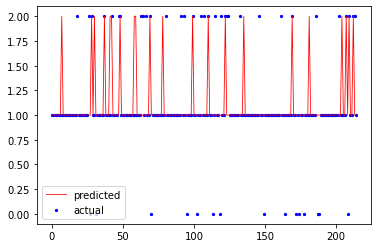

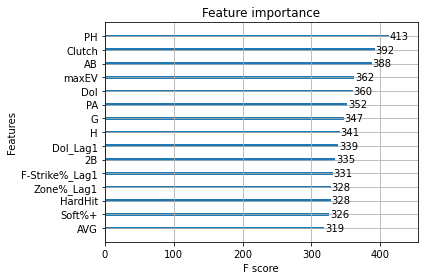

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


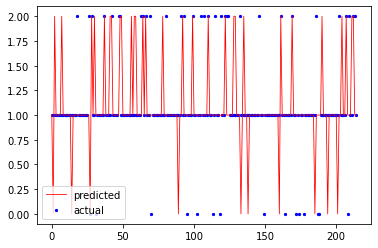

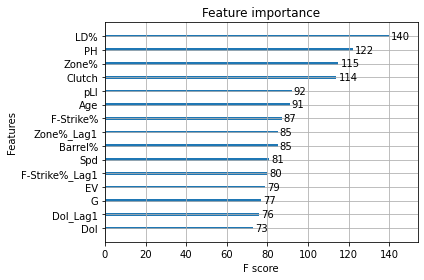

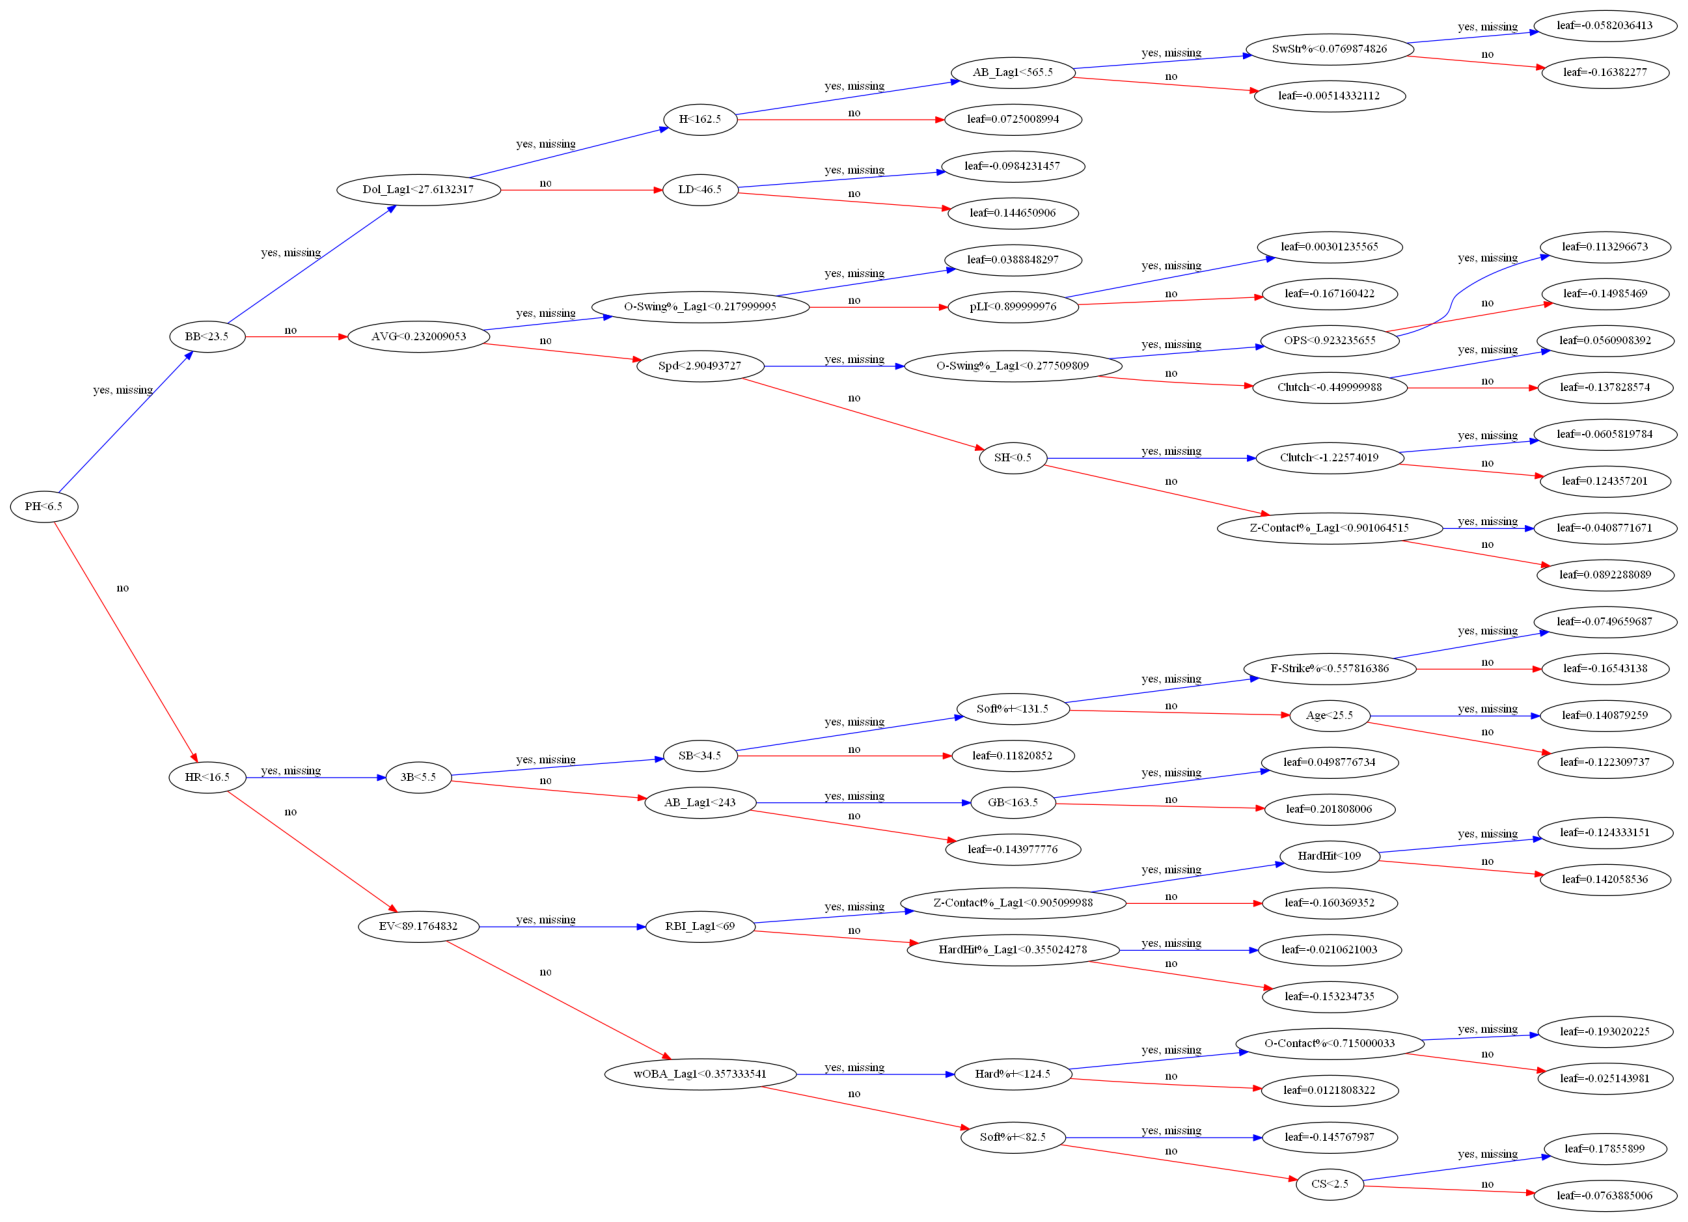

yrc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9206534422403734
Mean cross-validation score: 0.59
K-fold CV average score: 0.59
Precision: 64.14%
Recall: 73.95%
Outlier Precision: 71.15%
Outlier Recall: 9.62%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


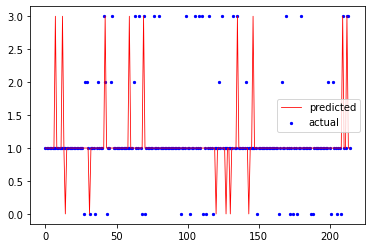

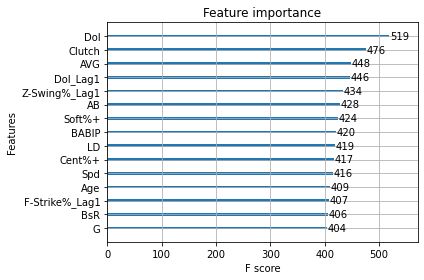

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


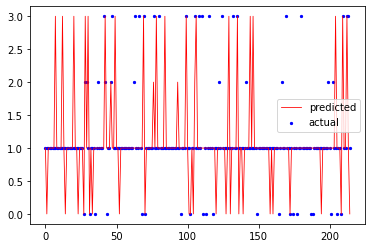

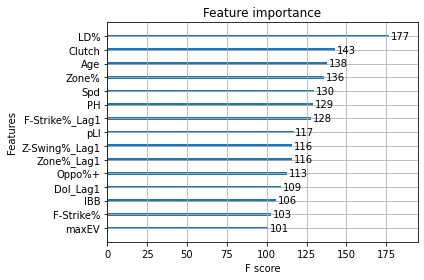

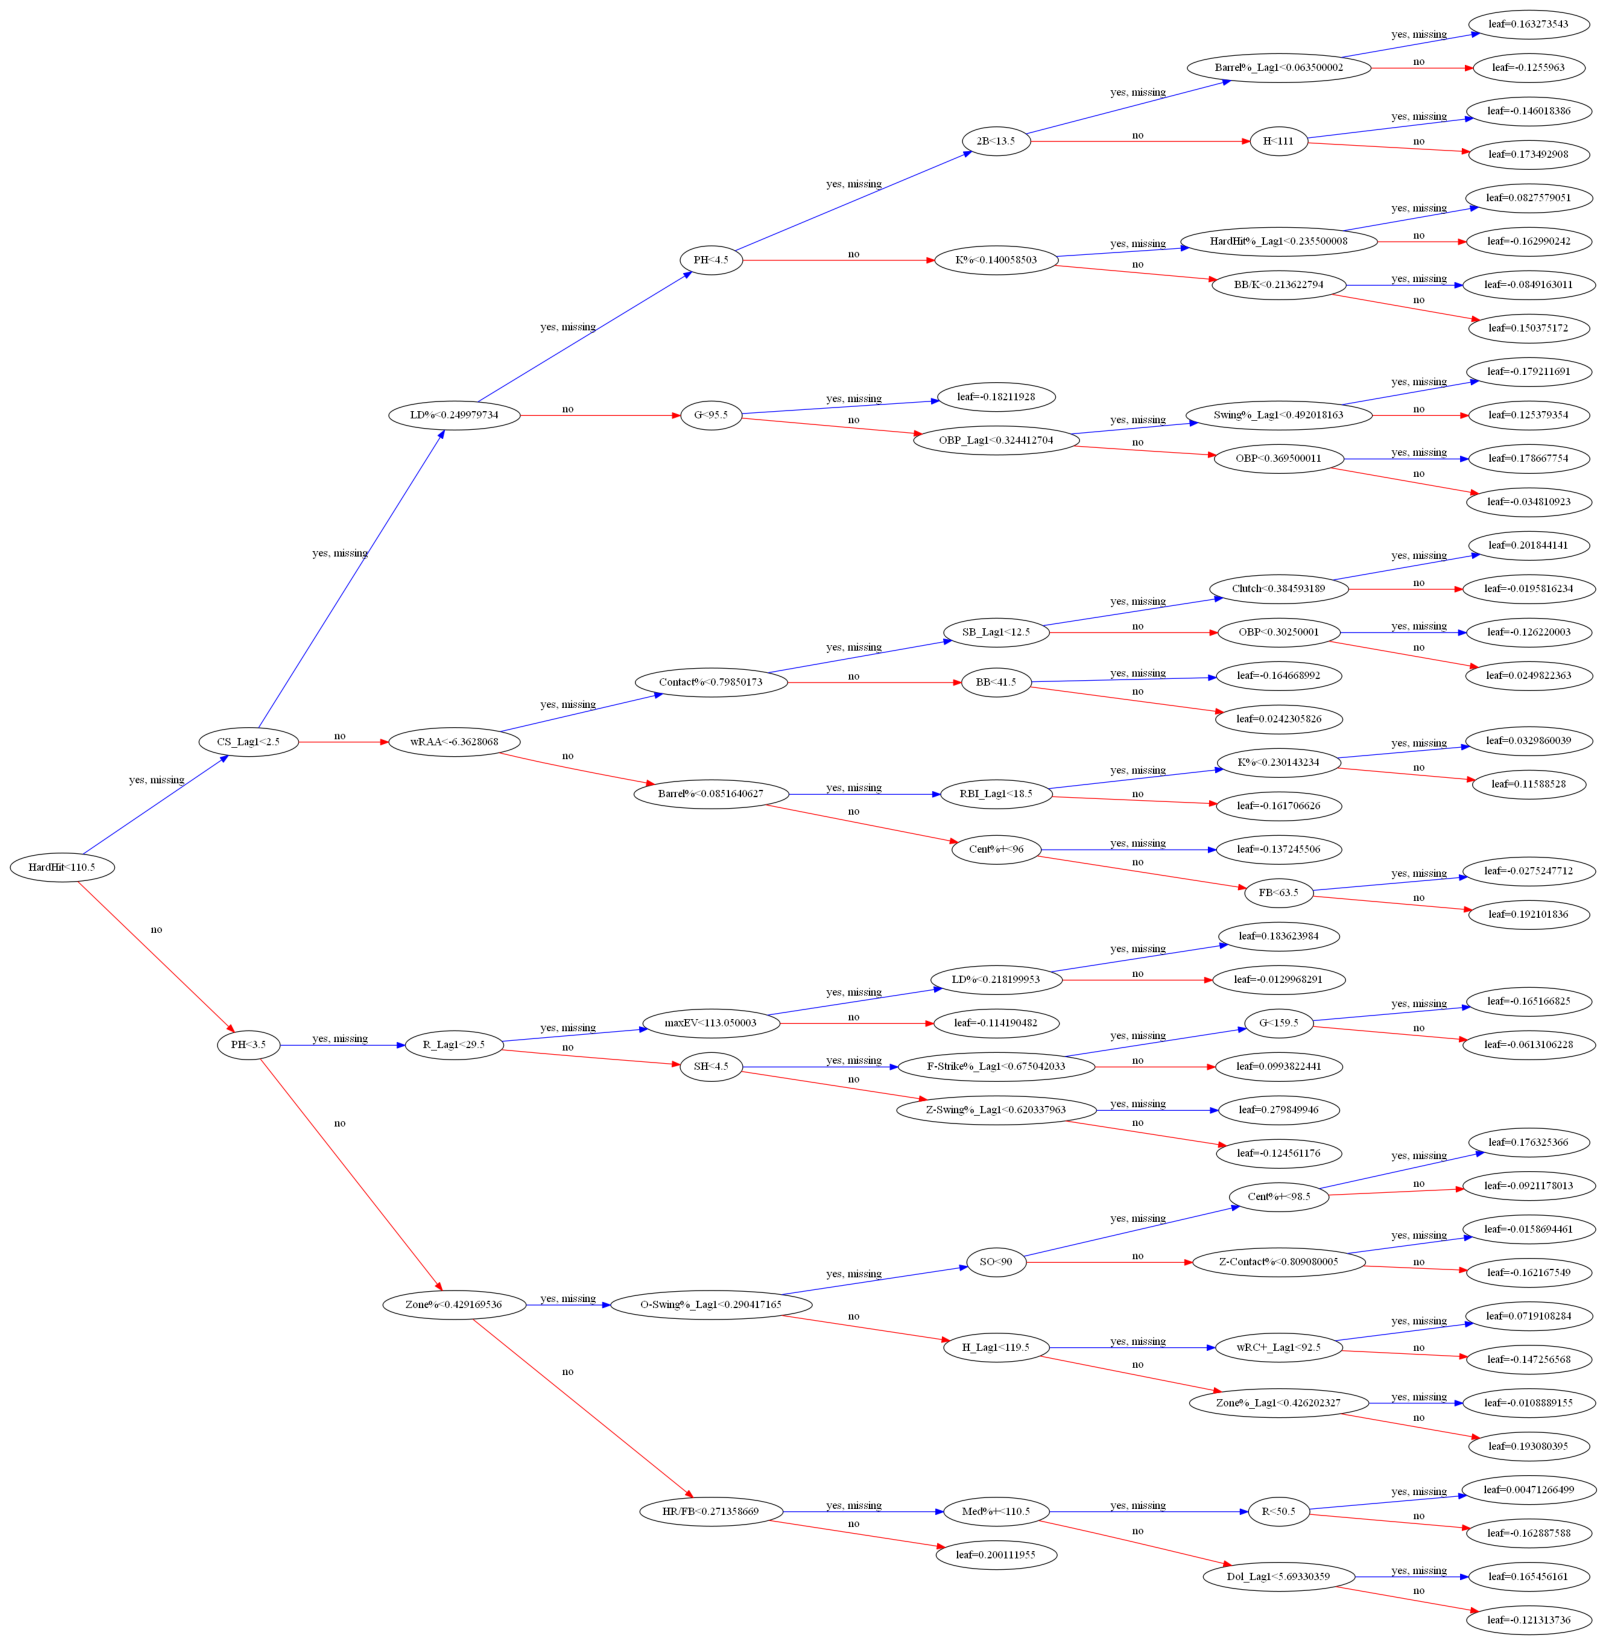

yhrc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9591598599766628
Mean cross-validation score: 0.65
K-fold CV average score: 0.66
Precision: 71.05%
Recall: 73.49%
Outlier Precision: 100.00%
Outlier Recall: 30.77%


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


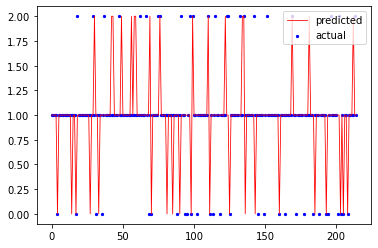

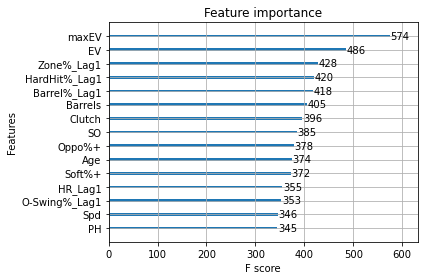

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


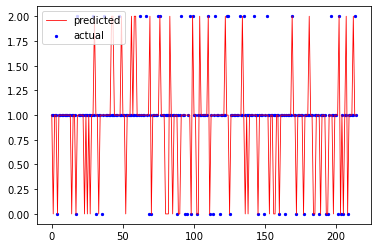

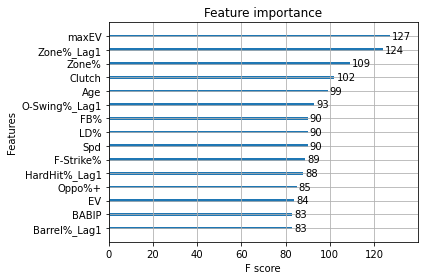

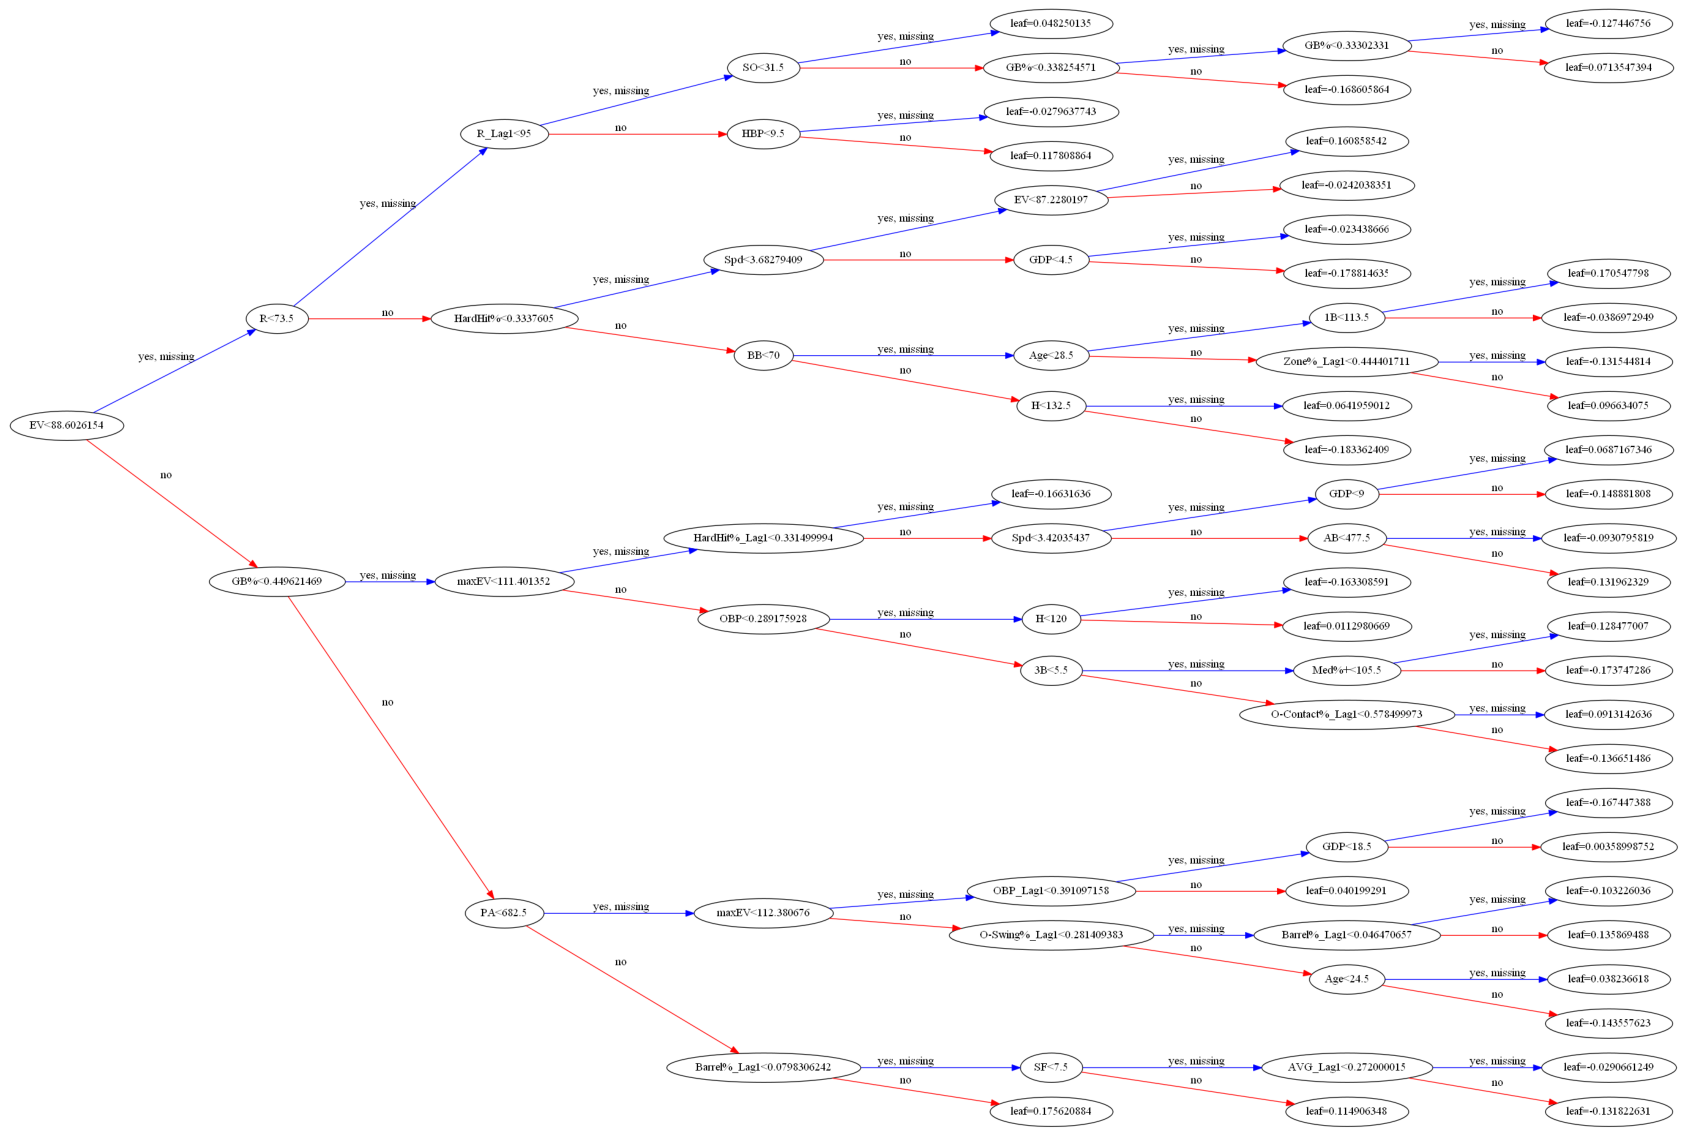

yrbic :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9171528588098017
Mean cross-validation score: 0.57
K-fold CV average score: 0.56
Precision: 68.20%
Recall: 73.02%
Outlier Precision: 75.93%
Outlier Recall: 9.26%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


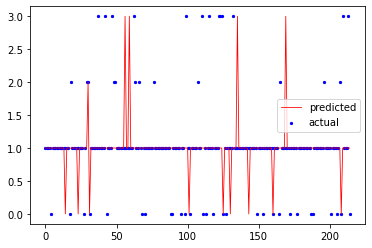

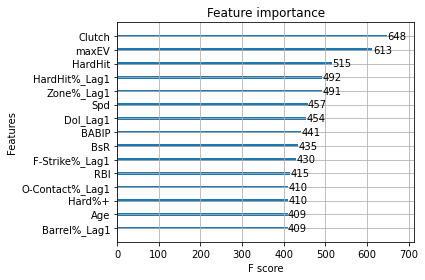

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


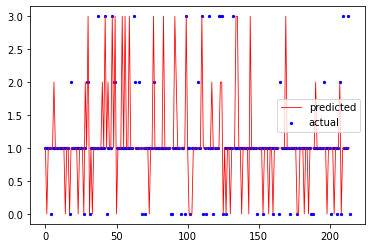

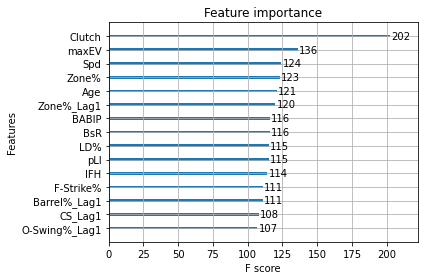

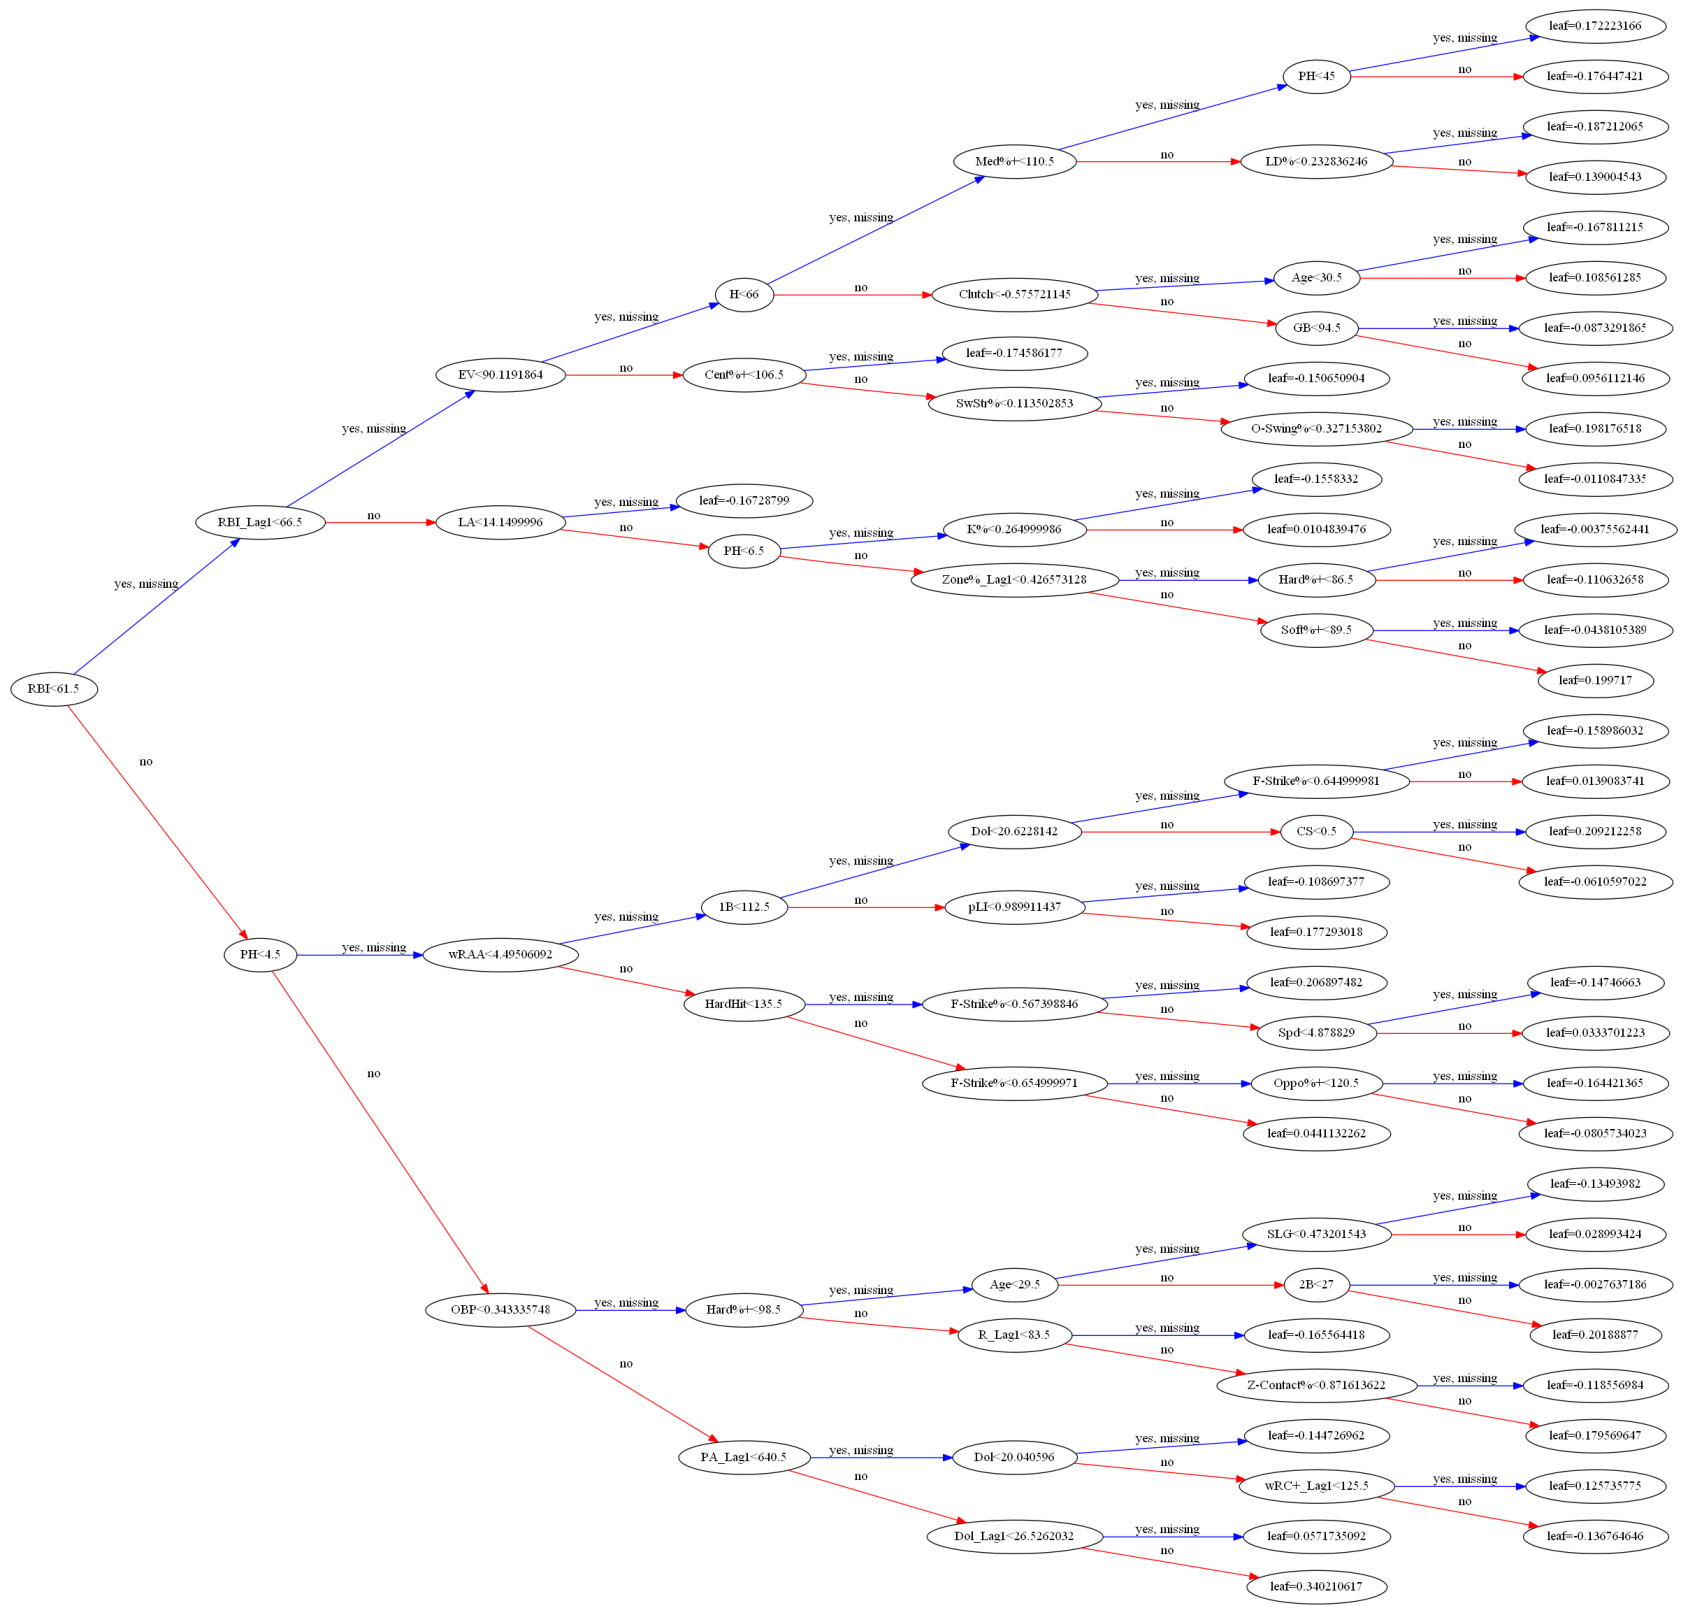

ysbc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9906651108518086
Mean cross-validation score: 0.91
K-fold CV average score: 0.91
Precision: 84.11%
Recall: 89.30%
Outlier Precision: 21.74%
Outlier Recall: 8.70%


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


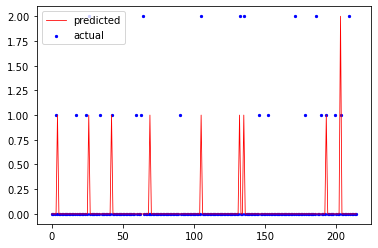

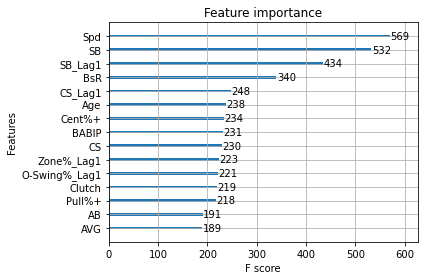

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


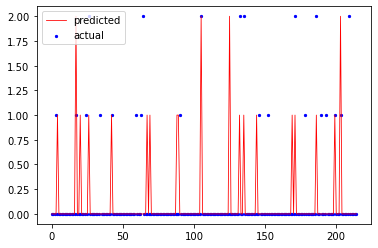

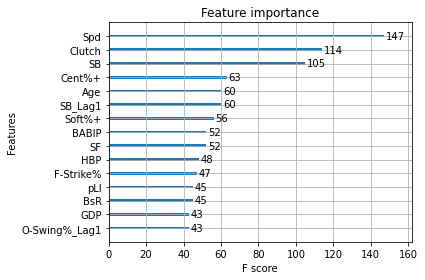

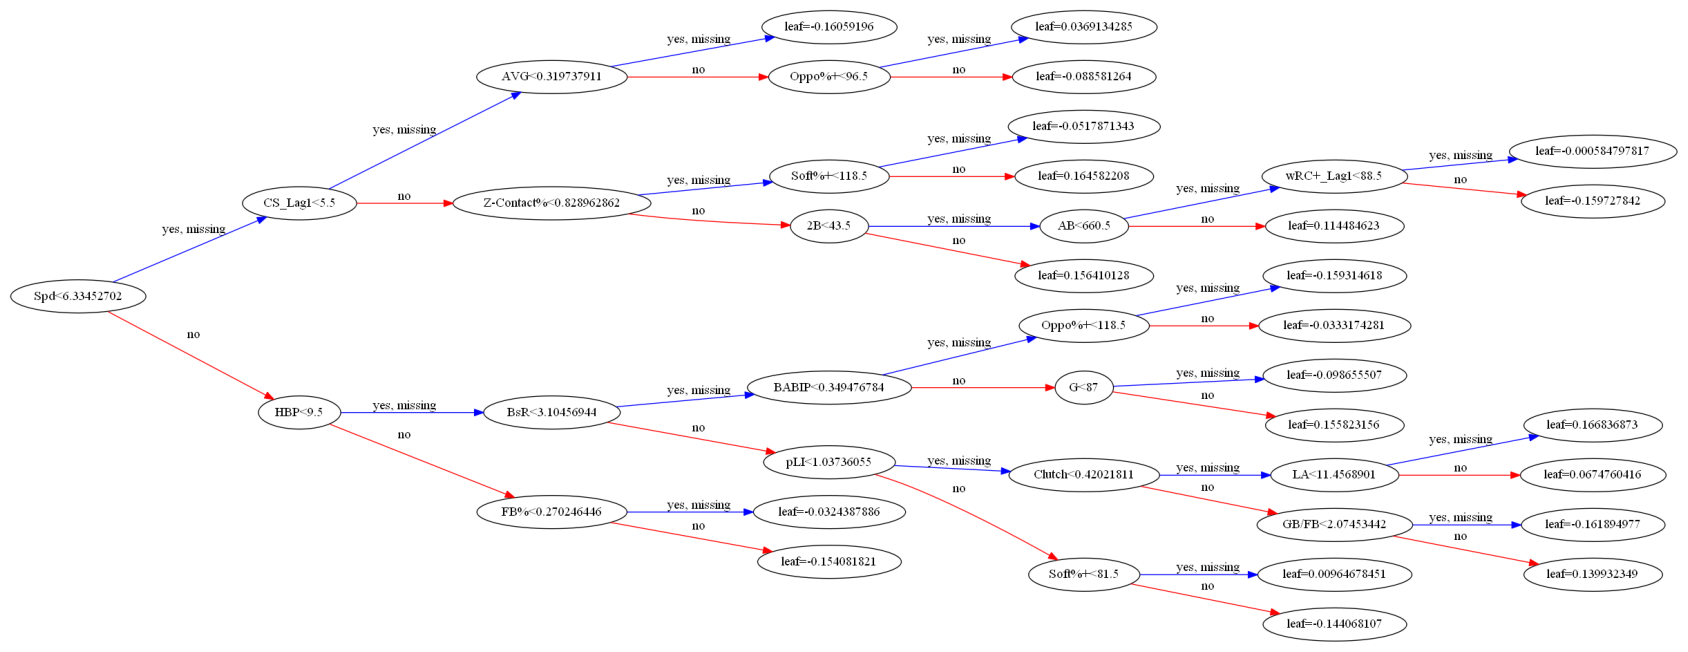

ycsc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9649941656942824
Mean cross-validation score: 0.75
K-fold CV average score: 0.75
Precision: 66.41%
Recall: 74.42%
Outlier Precision: 42.19%
Outlier Recall: 16.07%


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


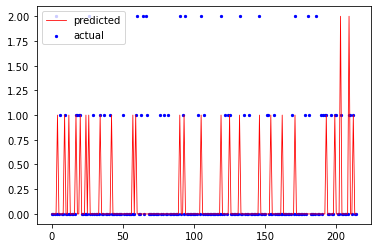

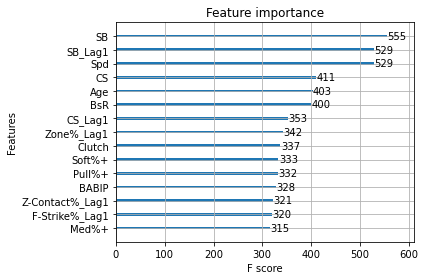

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


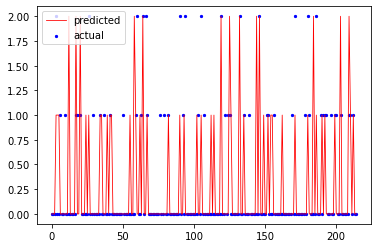

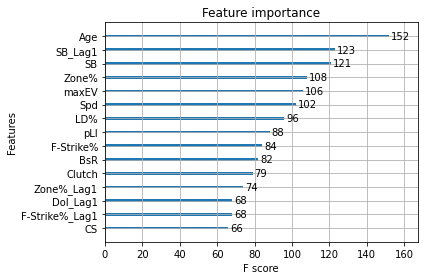

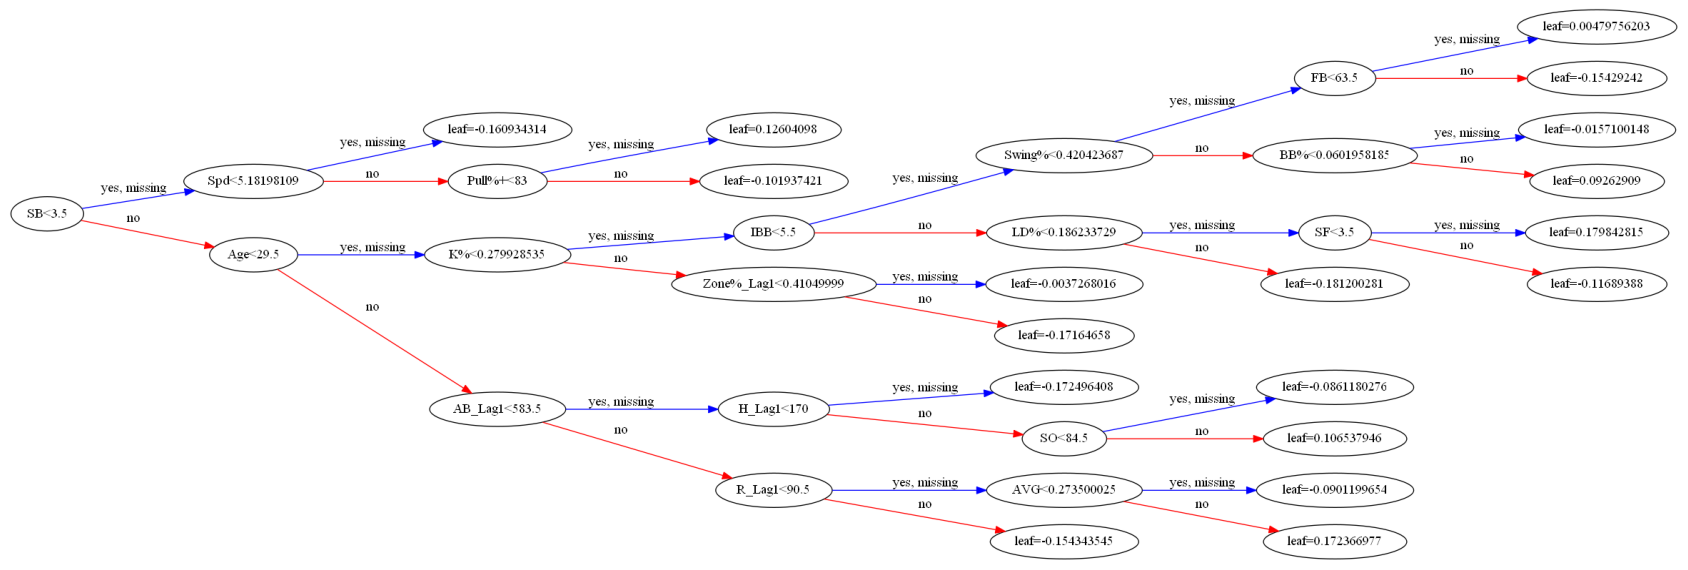

yavgc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9148191365227538
Mean cross-validation score: 0.61
K-fold CV average score: 0.60
Precision: 63.86%
Recall: 74.42%
Outlier Precision: 39.76%
Outlier Recall: 7.27%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


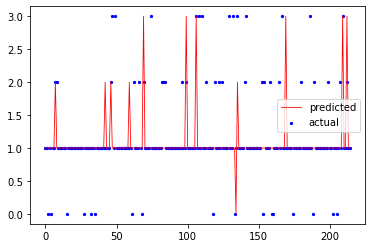

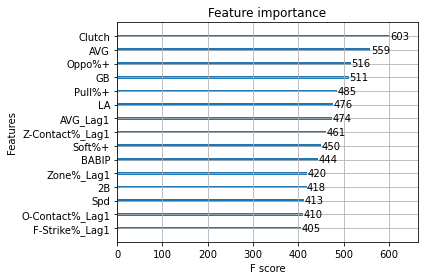

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


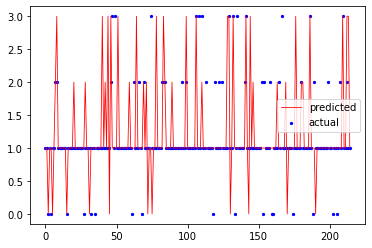

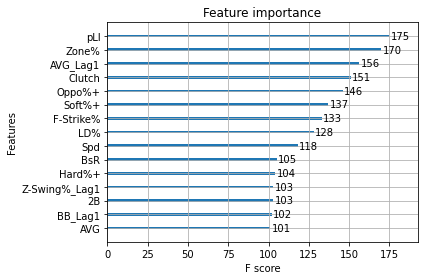

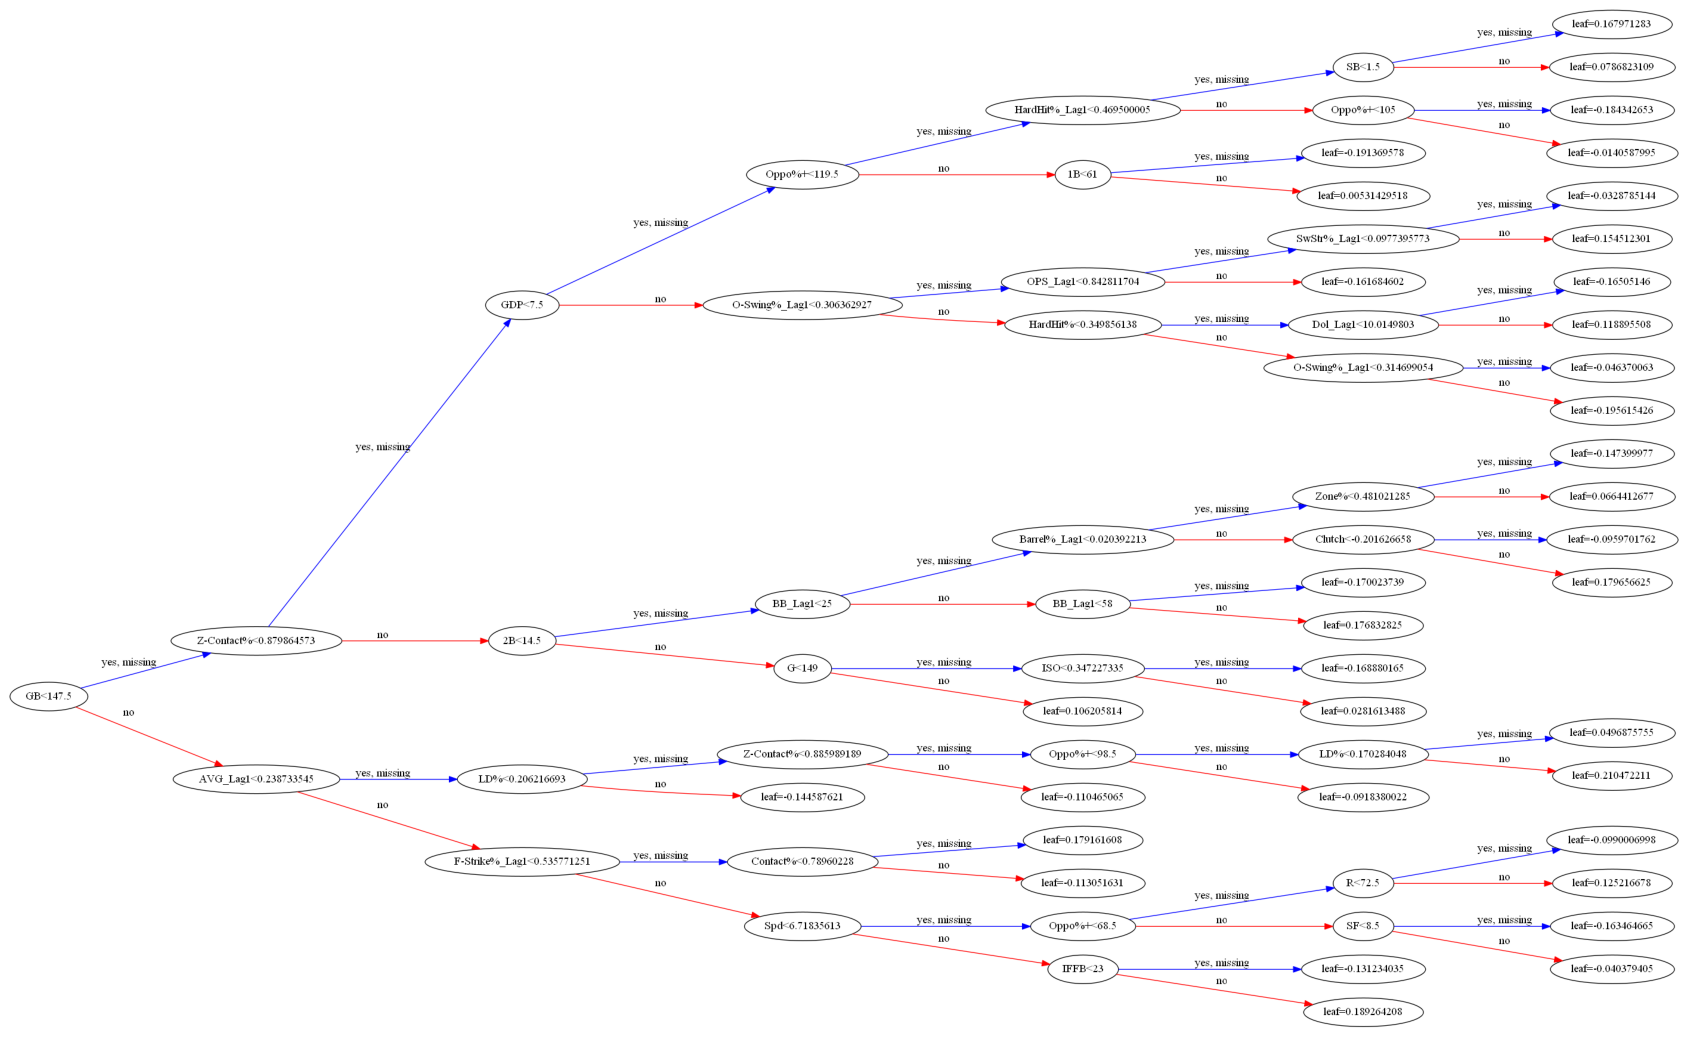

yobpc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9393232205367561
Mean cross-validation score: 0.67
K-fold CV average score: 0.66
Precision: 72.58%
Recall: 77.21%
Outlier Precision: 59.18%
Outlier Recall: 6.12%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


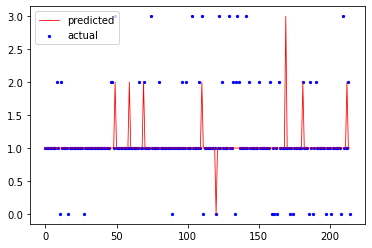

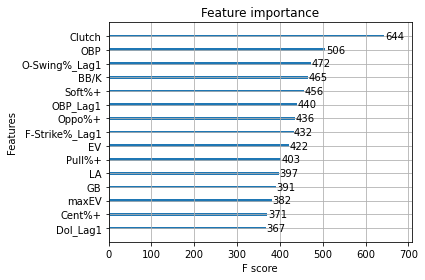

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


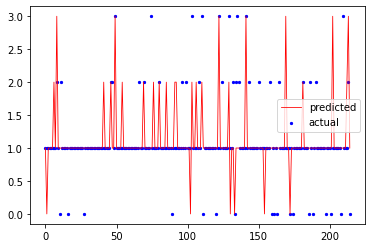

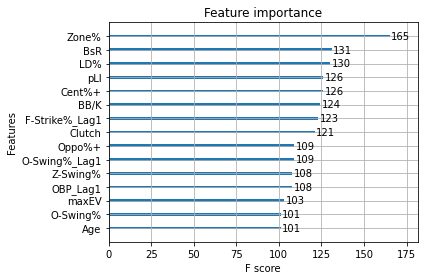

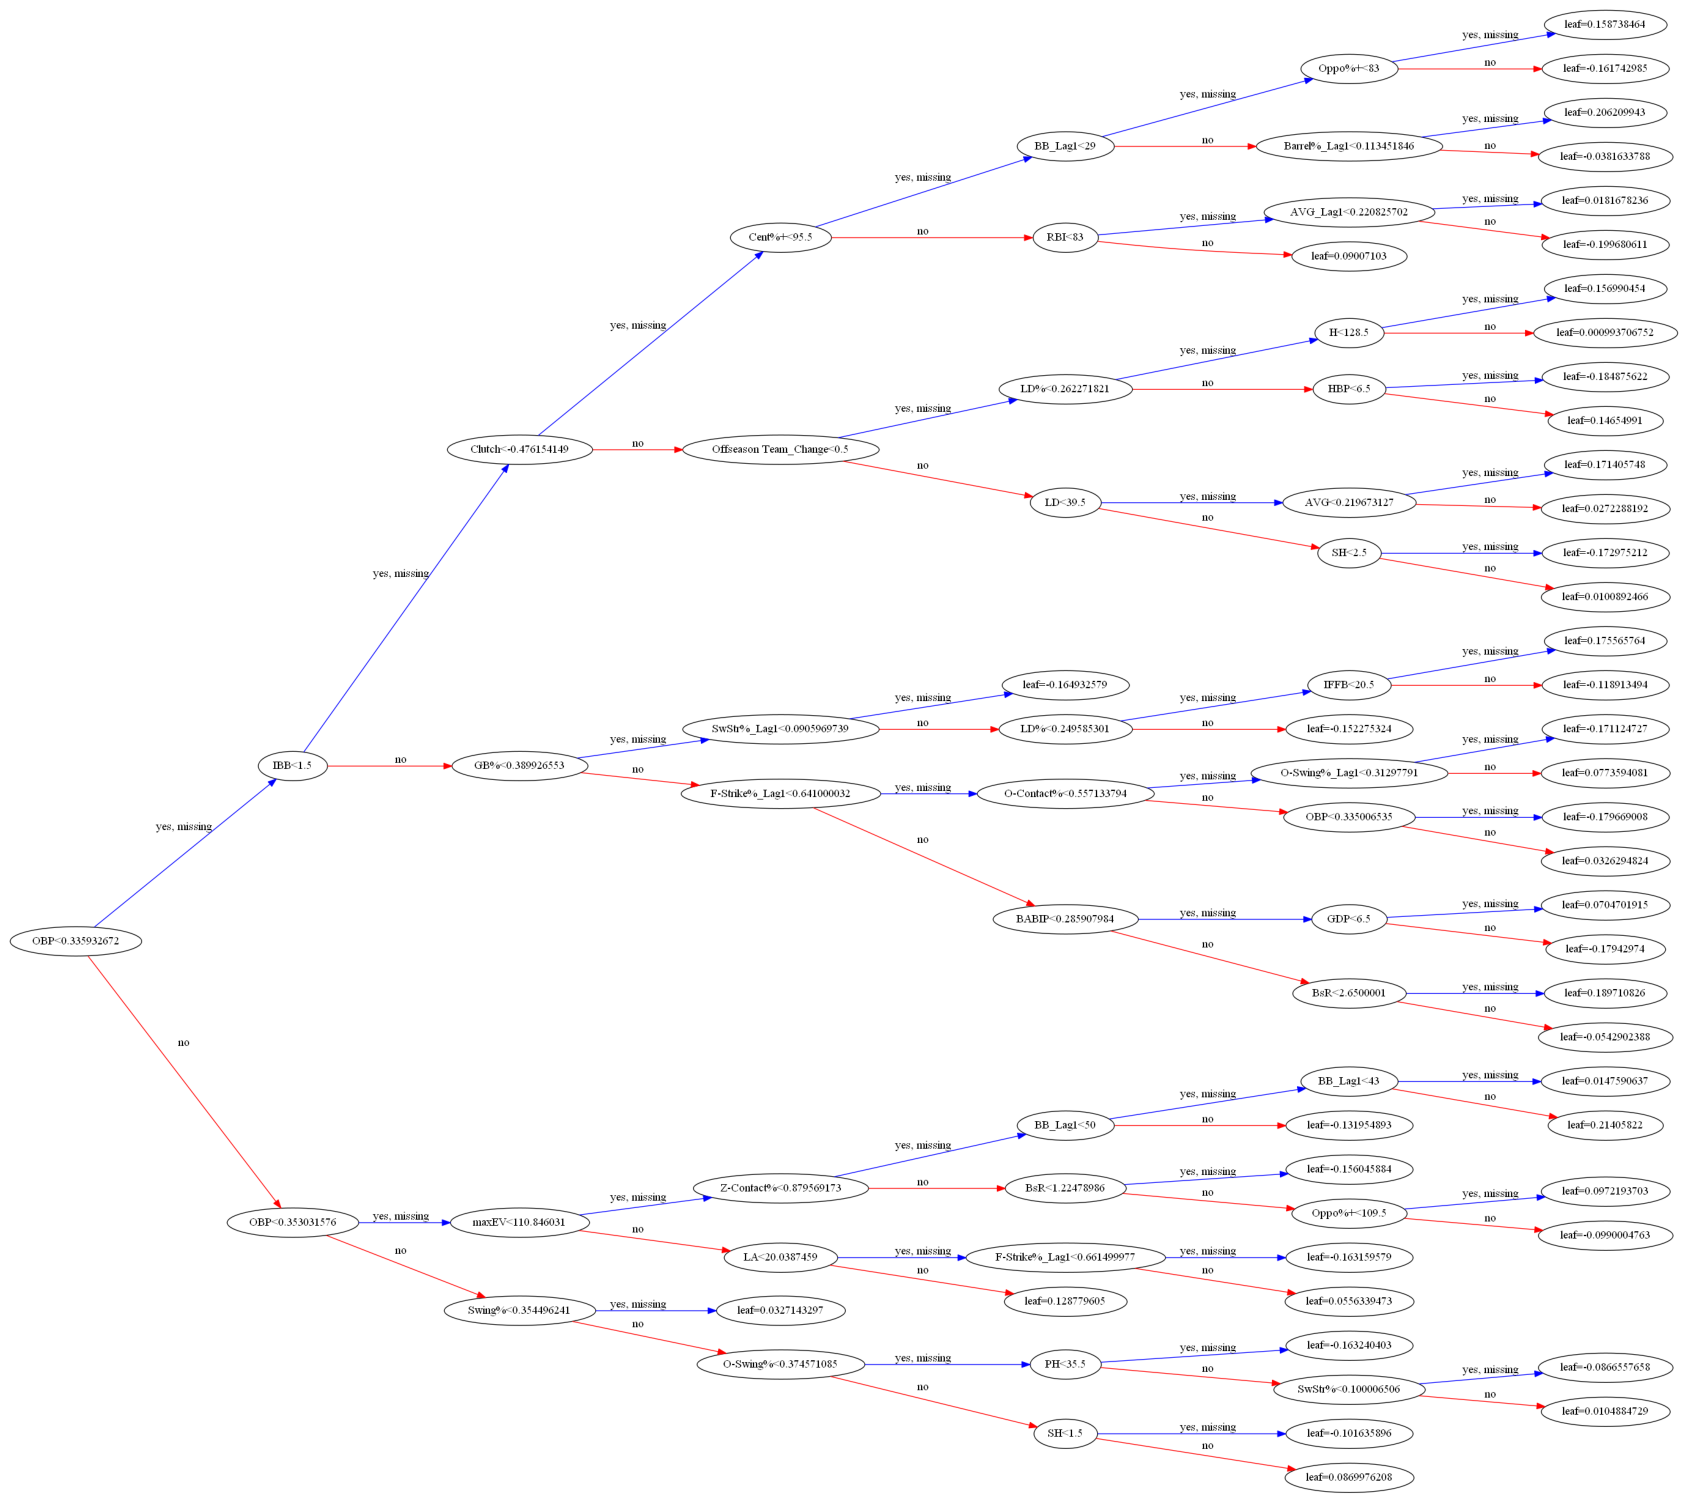

yopsc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9148191365227538
Mean cross-validation score: 0.58
K-fold CV average score: 0.56
Precision: 58.02%
Recall: 73.02%
Outlier Precision: 18.00%
Outlier Recall: 10.00%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


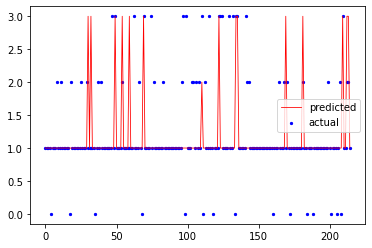

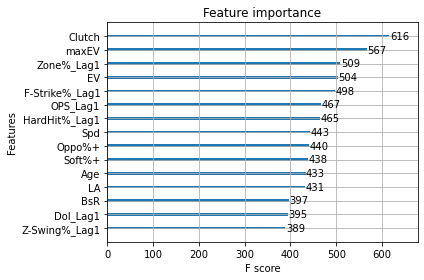

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


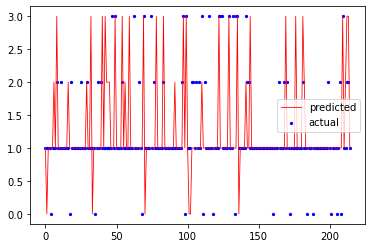

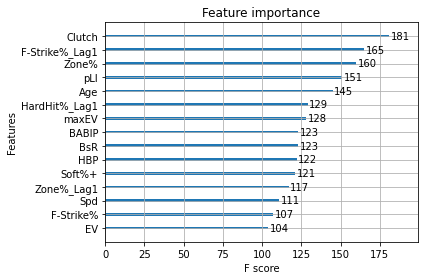

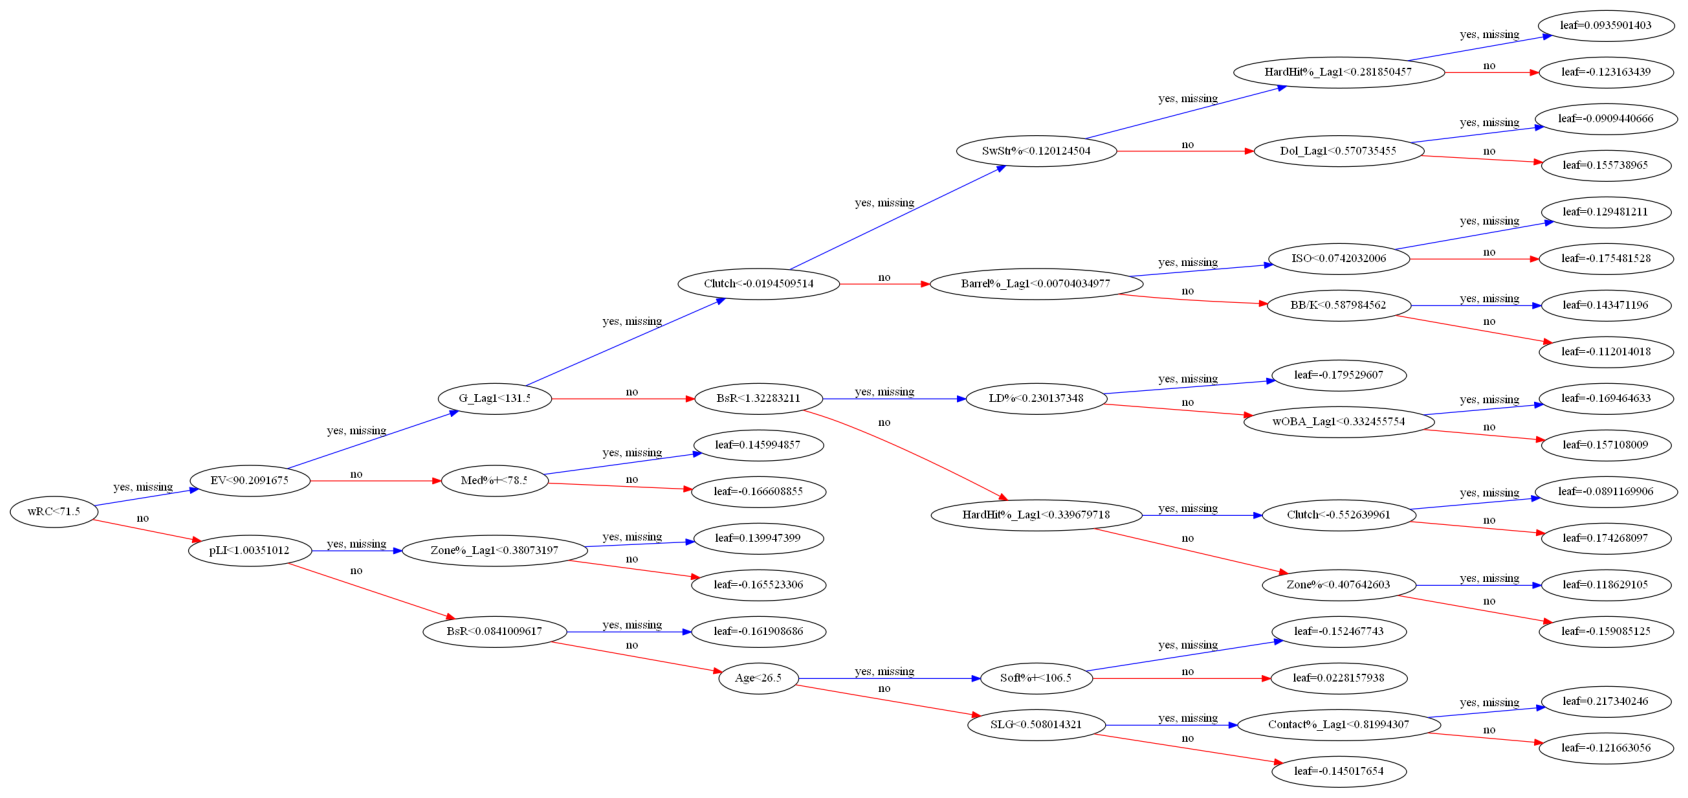

ydolc :
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.3, eval_metric='merror',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.01,
              max_delta_step=None, max_depth=5, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=0.5, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
Training score:  0.9929988331388565
Mean cross-validation score: 0.21
K-fold CV average score: 0.23
Precision: 24.53%
Recall: 30.70%
Outlier Precision: 29.92%
Outlier Recall: 34.07%


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


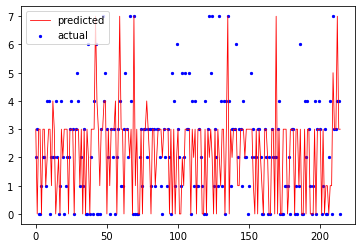

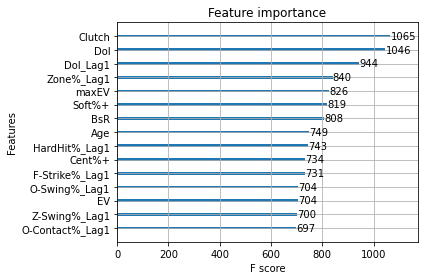

Pipeline(steps=[('smote', SMOTE(random_state=120)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, eval_metric='merror',
                               gamma=None, gpu_id=None, importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               use_label_encoder=False,


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


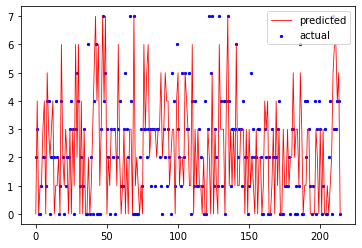

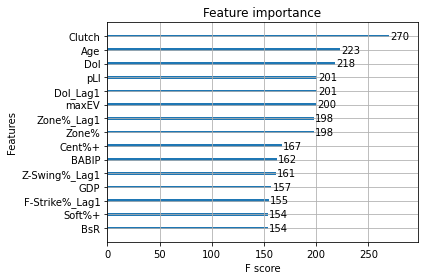

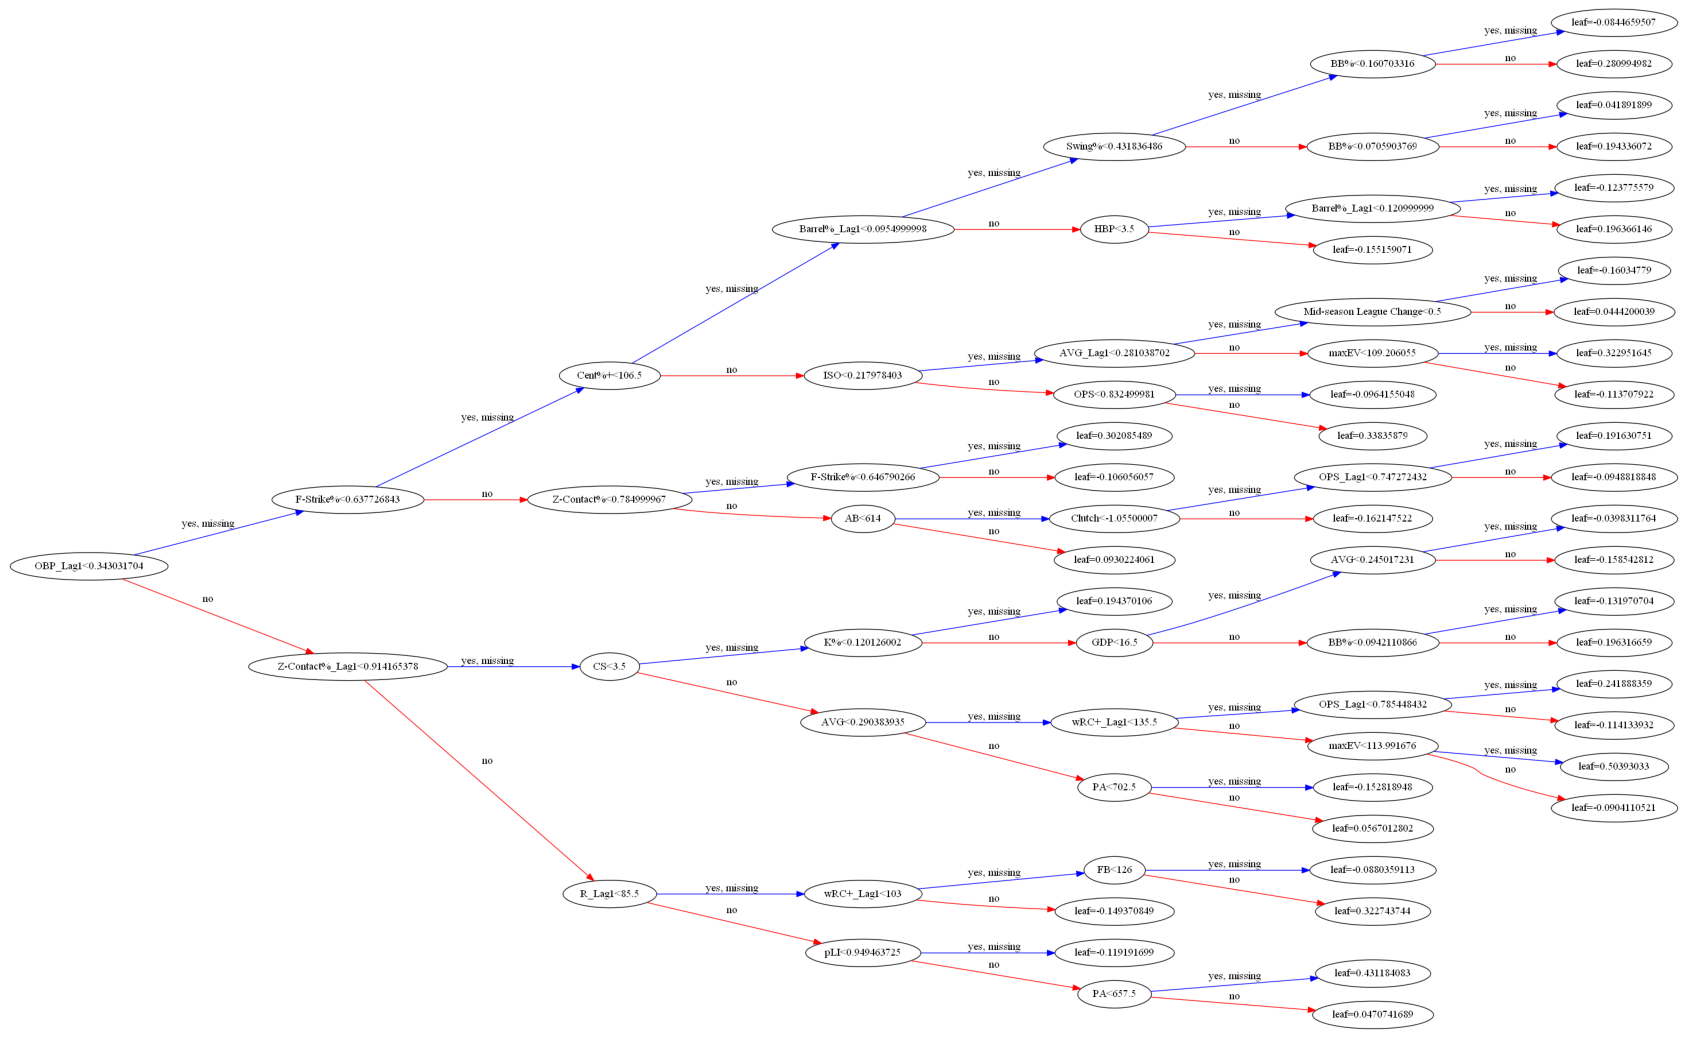

In [ ]:
# Train XGBoost classifier and tune hyperparemeters for each target variables
RANDOMSTATE = 120
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOMSTATE)
best_params_list = []

for i in range(len(ycs)):
    print(names[i],':')
    y = ycs[i]
    xtrain, xtest, ytrain, ytest = train_test_split(Xc, y, test_size=0.2, random_state=RANDOMSTATE)
    clf_tuning(xtrain, ytrain, names[i], kfold, nonoutliers[i])

In [ ]:
# Load 162-game scaled 2020 data: final prediction test set
df20 = pd.read_csv('2020_batting_scaled.csv')

dftest = df20.drop(['playerid', 'Name', 'Team', 'League', 'Team_Traded', 'League_Traded', 'Team_Lag1', 
          'League_Lag1', 'PA_Tgt', 'AB_Tgt', 'R_Tgt', 'HR_Tgt', 'RBI_Tgt', 'SB_Tgt', 'CS_Tgt', 'AVG_Tgt', 'OBP_Tgt', 'OPS_Tgt', 
            'Dol_Tgt', 'PA_Tgt_Cat', 'R_Tgt_Cat', 'HR_Tgt_Cat', 'RBI_Tgt_Cat', 'SB_Tgt_Cat', 'CS_Tgt_Cat', 'AVG_Tgt_Cat', 
            'OBP_Tgt_Cat', 'OPS_Tgt_Cat', 'Dol_Tgt_Cat', 'PA_Tgt_Code', 'R_Tgt_Code', 'HR_Tgt_Code', 'RBI_Tgt_Code', 
            'SB_Tgt_Code', 'CS_Tgt_Code', 'AVG_Tgt_Code', 'OBP_Tgt_Code', 'OPS_Tgt_Code', 'Dol_Tgt_Code', 'Season'
            ], axis=1)

In [ ]:
# Load all models, predict 2021 values for all statistics

pa_model = joblib.load('ypa_1619.joblib.dat')
df20['PA_21'] = pa_model.predict(dftest)

ab_model = joblib.load('yab_1619.joblib.dat')
df20['AB_21'] = ab_model.predict(dftest)

r_model = joblib.load('yr_1619.joblib.dat')
df20['R_21'] = r_model.predict(dftest)

hr_model = joblib.load('yhr_1619.joblib.dat')
df20['HR_21'] = hr_model.predict(dftest)

rbi_model = joblib.load('yrbi_1619.joblib.dat')
df20['RBI_21'] = rbi_model.predict(dftest)

sb_model = joblib.load('ysb_1619.joblib.dat')
df20['SB_21'] = sb_model.predict(dftest)

cs_model = joblib.load('ycs_1619.joblib.dat')
df20['CS_21'] = cs_model.predict(dftest)

avg_model = joblib.load('yavg_1619.joblib.dat')
df20['AVG_21'] = avg_model.predict(dftest)

obp_model = joblib.load('yobp_1619.joblib.dat')
df20['OBP_21'] = obp_model.predict(dftest)

ops_model = joblib.load('yops_1619.joblib.dat')
df20['OPS_21'] = ops_model.predict(dftest)

dol_model = joblib.load('ydol_1619.joblib.dat')
df20['Dol_21'] = dol_model.predict(dftest)

pa_cmodel = joblib.load('ypac_clf.joblib.dat')
df20['PA_21_Tier'] = pa_cmodel.predict(dftest)

r_cmodel = joblib.load('yrc_clf.joblib.dat')
df20['R_21_Tier'] = r_cmodel.predict(dftest)

hr_cmodel = joblib.load('yhrc_clf.joblib.dat')
df20['HR_21_Tier'] = hr_cmodel.predict(dftest)

rbi_cmodel = joblib.load('yrbic_clf.joblib.dat')
df20['RBI_21_Tier'] = rbi_cmodel.predict(dftest)

sb_cmodel = joblib.load('ysbc_clf.joblib.dat')
df20['SB_21_Tier'] = sb_cmodel.predict(dftest)

cs_cmodel = joblib.load('ycsc_clf.joblib.dat')
df20['CS_21_Tier'] = cs_cmodel.predict(dftest)

avg_cmodel = joblib.load('yavgc_clf.joblib.dat')
df20['AVG_21_Tier'] = avg_cmodel.predict(dftest)

obp_cmodel = joblib.load('yobpc_clf.joblib.dat')
df20['OBP_21_Tier'] = obp_cmodel.predict(dftest)

ops_cmodel = joblib.load('yopsc_clf.joblib.dat')
df20['OPS_21_Tier'] = ops_cmodel.predict(dftest)

dol_cmodel = joblib.load('ydolc_clf.joblib.dat')
df20['Dol_21_Tier'] = dol_cmodel.predict(dftest)

df20.to_csv('2021_batting_proj_1619_v2.csv')

In [ ]:
# Construct list of all XGBoost regression models
all_models = [pa_model, ab_model, r_model, hr_model, rbi_model, sb_model, cs_model, avg_model, obp_model, ops_model, dol_model]

In [ ]:
def shapsum(X, i):
    """Function to display and save SHAP summary plot."""
    explainer = shap.TreeExplainer(all_models[i])
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.title('Top 20 Features and Their Impact on Model Output: '+stat_names[i])
    plt.tight_layout()
    plt.savefig('shap_'+stat_names[i]+'.png')
    plt.show()
    

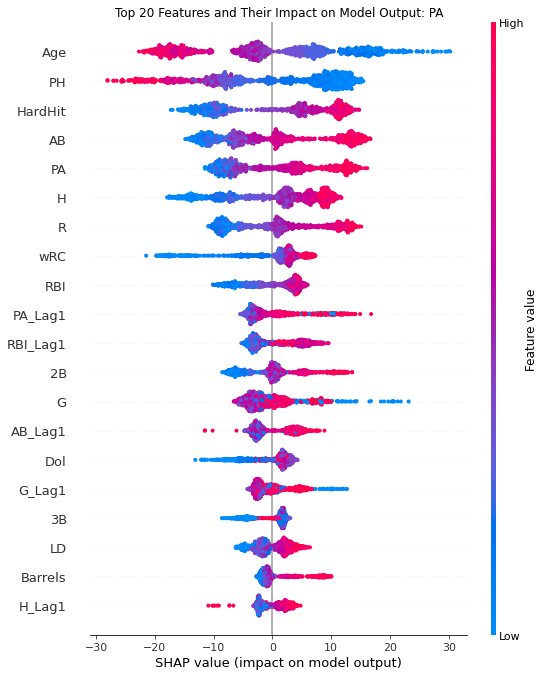

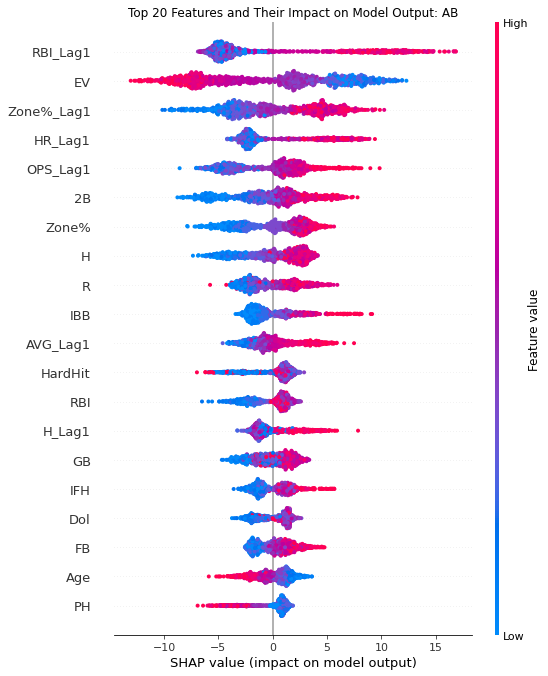

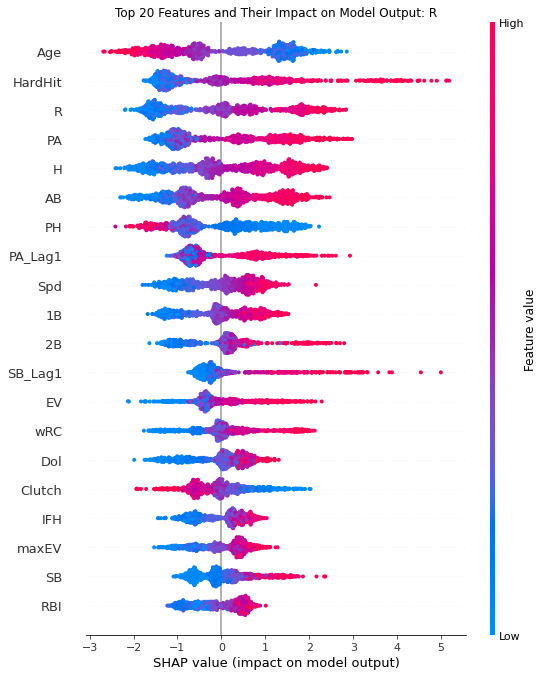

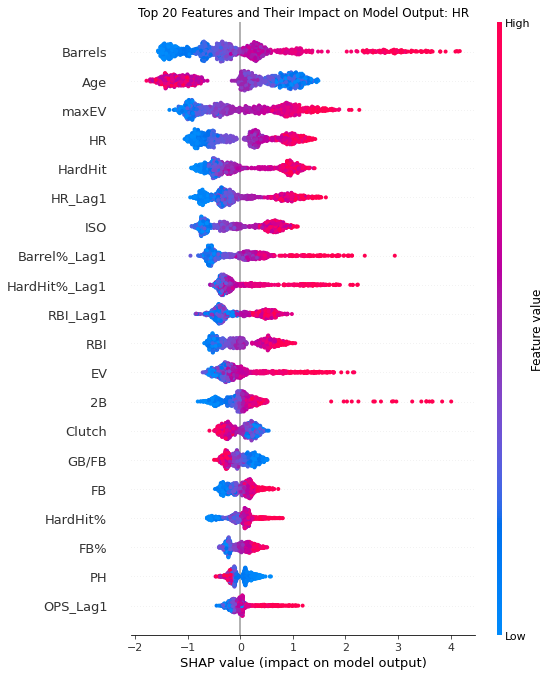

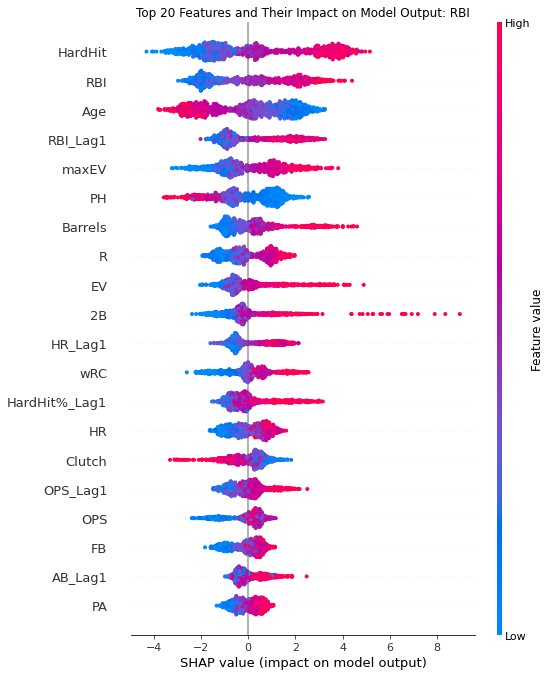

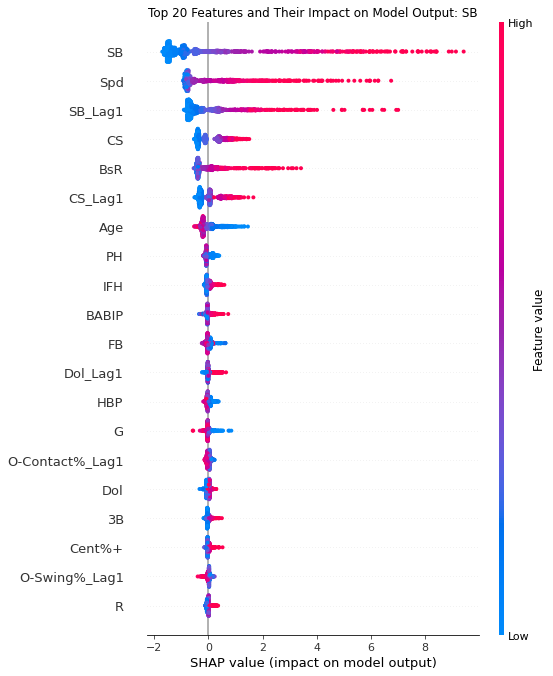

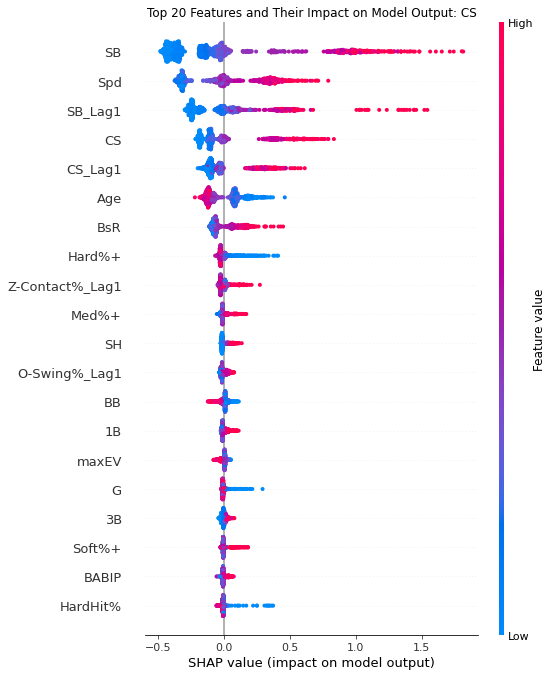

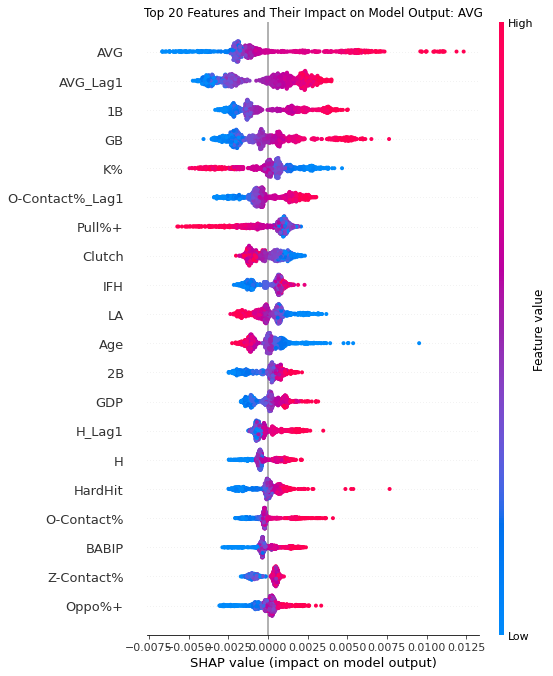

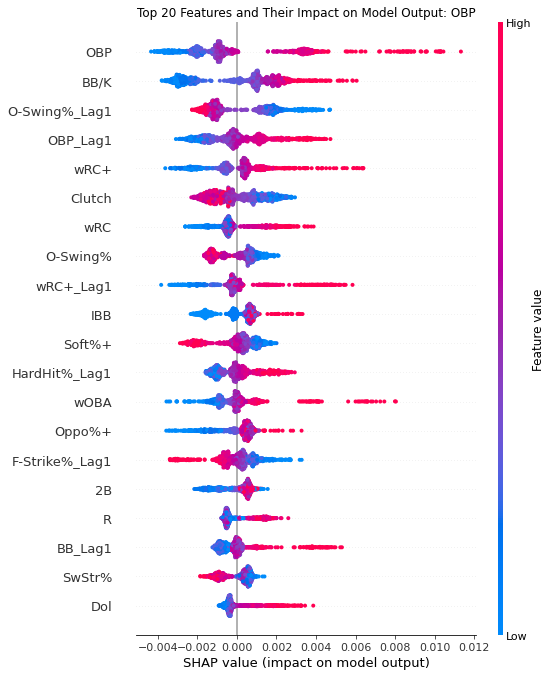

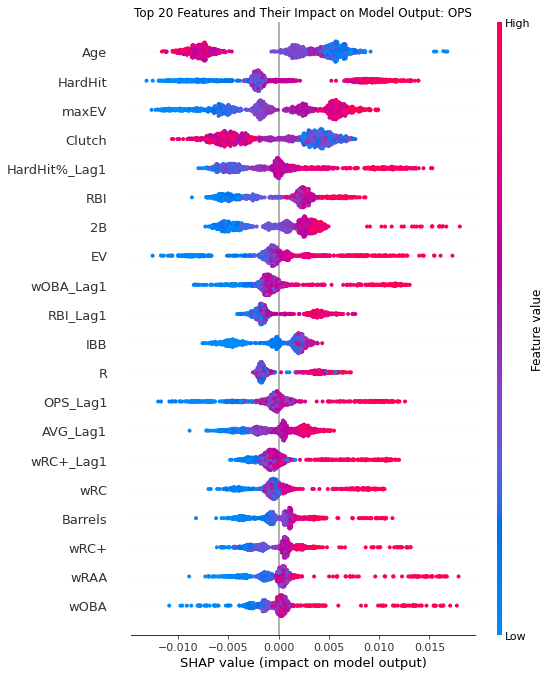

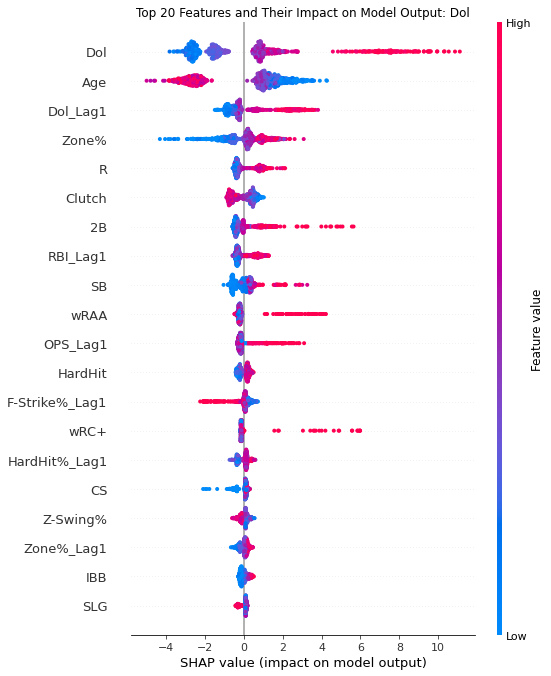

In [ ]:
# Display and save SHAP summary plots for all regression models
for i in range(len(all_models)):
    shapsum(X, i)